In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Policy Gradient

Iteration 0: Mean Return = -1966.2
Iteration 10: Mean Return = -1914.0
Iteration 20: Mean Return = -1946.4
Iteration 30: Mean Return = -1865.4
Iteration 40: Mean Return = -1818.6000000000001
Iteration 50: Mean Return = -1206.4
Iteration 60: Mean Return = -1590.0
Iteration 70: Mean Return = -1362.0
Iteration 80: Mean Return = -1950.0
Iteration 90: Mean Return = -2257.8
Iteration 100: Mean Return = -1217.4
Iteration 110: Mean Return = -1611.8000000000002
Iteration 120: Mean Return = -1597.2
Iteration 130: Mean Return = -1296.0
Iteration 140: Mean Return = -1274.4
Iteration 150: Mean Return = -1687.2
Iteration 160: Mean Return = -668.0
Iteration 170: Mean Return = -876.4000000000001
Iteration 180: Mean Return = -583.0
Iteration 190: Mean Return = -932.2
Iteration 200: Mean Return = -875.8000000000001
Iteration 210: Mean Return = -618.4000000000001
Iteration 220: Mean Return = -454.40000000000003
Iteration 230: Mean Return = -574.8000000000001
Iteration 240: Mean Return = -481.400000000000

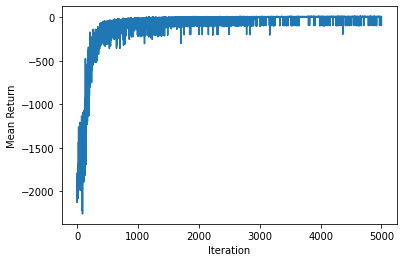

In [ ]:
import torch
import gym
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import random

###  policyGradient  ###
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_num = 2022
torch.manual_seed(seed_num)
torch.cuda.manual_seed(seed_num)
torch.cuda.manual_seed_all(seed_num)
np.random.seed(seed_num)
random.seed(seed_num)

class PolicyNet(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_size=64):
        super(PolicyNet, self).__init__()
        self.embedding = torch.nn.Embedding(500, input_size)
        # self.fc1 = torch.nn.Linear(input_size, hidden_layer_size)   # MLP
        self.layer1 = torch.nn.Sequential(
            torch.nn.Linear(input_size, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, hidden_layer_size),
            torch.nn.ReLU()
        )
        # self.fc2 = torch.nn.Linear(hidden_layer_size, output_size)  # MLP

        self.final = torch.nn.Linear(hidden_layer_size, output_size)
        self.softmax = torch.nn.Softmax(dim=0)                      # 소프트맥스 필요, 출력 값이 각 action을 실행할 '확률'이라서

    def forward(self, x):
        # print(x)
        # x = torch.from_numpy(x).float()
        x= torch.LongTensor([x])
        x = self.embedding(x)
        x= x.squeeze(0)

        return self.softmax(self.final(self.layer1(x)))

    def get_action_and_logp(self, x):
        action_prob = self.forward(x)  # action_prob : 각 action을 실행할 '확률'값들에 대한 tensor ,  ex) [0.1, 0.5, 0.2, 0.2]
        m = torch.distributions.Categorical(action_prob)  # Categorical한 대상에 대해 확률분포를 생성함. ex) action_prob=[0.1, 0.5, 0.2, 0.2]라면, 0번째 action을 뽑을 확률 0.1, 1번째 action을 뽑을 확률 0.5

        action = m.sample()                               # 출력값은 tensor(3) or tensor(1), or tensor(0) 등 index로 출력함
        # print(m.sample())                                 # 출력값은 tensor(3) or tensor(1), or tensor(0) 등 index로 출력함
        logp = m.log_prob(action)                         # log_prob은 확률값을 log로 변환시키는 함수 , log(tensor(0))과 동일 즉, log(0번째 action의 확률)과 동일
        # print(logp)                                     # 출력 : tensor(-2.3026)   // np.log(0.1)  = -2.3025850929940455
        return action.item(), logp                        # action_index , log 취한 action 선택 확률

    def act(self, x):
        action, _ = self.get_action_and_logp(x)
        return action

class ValueNet(torch.nn.Module):
    def __init__(self, input_size, hidden_layer_size=64):
        super(ValueNet, self).__init__()
        self.embedding = torch.nn.Embedding(500, input_size)
        self.fc1 = torch.nn.Linear(input_size, hidden_layer_size)
        self.fc2 = torch.nn.Linear(hidden_layer_size, 6)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Linear(input_size, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, hidden_layer_size),
            torch.nn.ReLU()
        )
        self.final = torch.nn.Linear(hidden_layer_size, 6)

    def forward(self, x):
        x= torch.LongTensor([x])
        x = self.embedding(x)
        x= x.squeeze(0)
        return self.final(self.layer1(x))
        # return self.fc2(torch.nn.functional.relu(self.fc1(x)))

def policyGradient(env, max_num_steps=500, gamma=0.98, lr=0.002,
                   num_traj=10, num_iter=200):
    input_size = env.observation_space.n  ## STATE SPACE (STATE의 개수)
    output_size = env.action_space.n             ## ACTION의 개수
    Trajectory = namedtuple('Trajectory', 'states actions rewards dones logp')    # 'Trajectory'에 states actions rewards dones logp 튜플을 할당함


    def collect_trajectory():  # Trajectory 모으는 함수 (1 episode 돌리는 함수)
        state_list = []
        action_list = []
        reward_list = []
        dones_list = []
        logp_list = []
        state = env.reset()
        done = False
        steps = 0
        while not done and steps <= max_num_steps:   # done(에피소드 종료) 될때까지 루프 
            action, logp = policy.get_action_and_logp(state)  # policy = PolicyNet(input_size, output_size)
            newstate, reward, done, _, _ = env.step(action)    # s_, r, terminated, truncated, _
            state_list.append(state)
            action_list.append(action)
            reward_list.append(reward)
            dones_list.append(done)
            logp_list.append(logp)
            steps += 1
            state = newstate

        traj = Trajectory(states=state_list, actions=action_list,
                          rewards=reward_list, logp=logp_list, dones=dones_list)
      # print(traj)  # Trajectory(states=[array([ 9.5363184e-06,  9.3068667e-03,  3.0773466e-02, -4.3019545e-03],
      # dtype=float32), array([ 1.9567365e-04, -1.8624260e-01,  3.0687427e-02,  2.9792932e-01],
      # dtype=float32), array([-0.00352918,  0.00842878,  0.03664601,  0.01508044], dtype=float32), array([-0.0033606 ,  0.20300654,  0.03694762, -0.26581872], dtype=float32), array([ 0.00069953,  0.3975822 ,  0.03163125, -0.54662293], dtype=float32), array([ 0.00865117,  0.5922458 ,  0.02069879, -0.82917416], dtype=float32), array([ 0.02049609,  0.3968471 ,  0.00411531, -0.5300539 ], dtype=float32), array([ 0.02843303,  0.5919109 , -0.00648577, -0.82143724], dtype=float32), array([ 0.04027125,  0.3968783 , -0.02291452, -0.5308013 ], dtype=float32), array([ 0.04820881,  0.59231496, -0.03353054, -0.8306156 ], dtype=float32), array([ 0.06005511,  0.39766696, -0.05014285, -0.54866385], dtype=float32), array([ 0.06800845,  0.20328394, -0.06111613, -0.27219164], dtype=float32), array([ 0.07207413,  0.0090849 , -0.06655996,  0.00060612], dtype=float32), array([ 0.07225583, -0.18502247, -0.06654784,  0.27156827], dtype=float32), array([ 0.06855538, -0.37913483, -0.06111648,  0.5425417 ], dtype=float32), array([ 0.06097268, -0.18320957, -0.05026564,  0.23124543], dtype=float32), array([ 0.05730849,  0.01259326, -0.04564074, -0.07685973], dtype=float32), array([ 0.05756036, -0.1818457 , -0.04717793,  0.20108126], dtype=float32), array([ 0.05392344, -0.37626228, -0.0431563 ,  0.4785165 ], dtype=float32), array([ 0.0463982 , -0.5707492 , -0.03358598,  0.75729126], dtype=float32), array([ 0.03498321, -0.37518087, -0.01844015,  0.45423177], dtype=float32), array([ 0.02747959, -0.5700373 , -0.00935551,  0.7410456 ], dtype=float32), array([ 0.01607885, -0.37478745,  0.0054654 ,  0.44543317], dtype=float32), array([ 0.0085831 , -0.5699863 ,  0.01437406,  0.7398339 ], dtype=float32), array([-0.00281663, -0.76530373,  0.02917074,  1.0370055 ], dtype=float32), array([-0.0181227 , -0.57058144,  0.04991085,  0.75362134], dtype=float32), array([-0.02953433, -0.7663547 ,  0.06498328,  1.0615833 ], dtype=float32), array([-0.04486142, -0.5721506 ,  0.08621494,  0.78998363], dtype=float32), array([-0.05630443, -0.768344  ,  0.10201462,  1.1084964 ], dtype=float32), array([-0.07167131, -0.5746998 ,  0.12418454,  0.8494806 ], dtype=float32), array([-0.08316531, -0.38147032,  0.14117415,  0.59828496], dtype=float32), array([-0.09079471, -0.18857652,  0.15313986,  0.35319027], dtype=float32), array([-0.09456625,  0.00407392,  0.16020367,  0.11244383], dtype=float32), array([-0.09448477,  0.19658096,  0.16245253, -0.12572043], dtype=float32), array([-0.09055315,  0.38904798,  0.15993813, -0.36306855], dtype=float32), array([-0.08277219,  0.58157825,  0.15267676, -0.60135657], dtype=float32), array([-0.07114062,  0.774272  ,  0.14064963, -0.8423221 ], dtype=float32), array([-0.05565519,  0.5775394 ,  0.12380318, -0.50892246], dtype=float32), array([-0.0441044 ,  0.3809106 ,  0.11362474, -0.17993148], dtype=float32), array([-0.03648619,  0.18436155,  0.11002611,  0.14632481], dtype=float32), array([-0.03279895, -0.01214998,  0.1129526 ,  0.47159216], dtype=float32), array([-0.03304195, -0.20867096,  0.12238444,  0.79763263], dtype=float32), array([-0.03721537, -0.01542167,  0.1383371 ,  0.54581815], dtype=float32), array([-0.03752381,  0.17751318,  0.14925346,  0.29972214], dtype=float32), array([-0.03397354, -0.01938604,  0.15524791,  0.6355052 ], dtype=float32), array([-0.03436126,  0.17326893,  0.167958  ,  0.395458  ], dtype=float32), array([-0.03089589,  0.36565927,  0.17586717,  0.16008124], dtype=float32), array([-0.0235827 ,  0.5578845 ,  0.17906879, -0.07237025], dtype=float32), array([-0.01242501,  0.75004774,  0.1776214 , -0.30364075], dtype=float32), array([0.00257595, 0.55289793, 0.17154858, 0.0393778 ], dtype=float32), array([ 0.0136339 ,  0.74519783,  0.17233613, -0.19464979], dtype=float32), array([0.02853786, 0.5480834 , 0.16844313, 0.14705835], dtype=float32), array([ 0.03949953,  0.74044305,  0.1713843 , -0.08810893], dtype=float32), array([0.05430839, 0.54333186, 0.16962212, 0.25336695], dtype=float32), array([0.06517503, 0.73567706, 0.17468946, 0.01861984], dtype=float32), array([ 0.07988857,  0.9279195 ,  0.17506185, -0.21425721], dtype=float32), array([0.09844696, 0.7307833 , 0.17077671, 0.12813324], dtype=float32), array([0.11306263, 0.53367877, 0.17333938, 0.46945378], dtype=float32), array([0.1237362 , 0.33658645, 0.18272845, 0.8113689 ], dtype=float32), array([0.13046794, 0.13949473, 0.19895583, 1.1555083 ], dtype=float32)], actions=[0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1], rewards=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], dones=[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True], logp=[tensor(-0.7011, grad_fn=<SqueezeBackward1>), tensor(-0.4942, grad_fn=<SqueezeBackward1>), tensor(-0.6693, grad_fn=<SqueezeBackward1>), tensor(-0.8719, grad_fn=<SqueezeBackward1>), tensor(-1.0927, grad_fn=<SqueezeBackward1>), tensor(-0.3000, grad_fn=<SqueezeBackward1>), tensor(-1.0943, grad_fn=<SqueezeBackward1>), tensor(-0.2976, grad_fn=<SqueezeBackward1>), tensor(-1.1101, grad_fn=<SqueezeBackward1>), tensor(-0.2912, grad_fn=<SqueezeBackward1>), tensor(-0.3850, grad_fn=<SqueezeBackward1>), tensor(-0.5034, grad_fn=<SqueezeBackward1>), tensor(-0.6458, grad_fn=<SqueezeBackward1>), tensor(-0.8513, grad_fn=<SqueezeBackward1>), tensor(-0.3972, grad_fn=<SqueezeBackward1>), tensor(-0.5714, grad_fn=<SqueezeBackward1>), tensor(-0.6144, grad_fn=<SqueezeBackward1>), tensor(-0.8118, grad_fn=<SqueezeBackward1>), tensor(-1.0638, grad_fn=<SqueezeBackward1>), tensor(-0.2649, grad_fn=<SqueezeBackward1>), tensor(-1.0635, grad_fn=<SqueezeBackward1>), tensor(-0.2634, grad_fn=<SqueezeBackward1>), tensor(-1.0795, grad_fn=<SqueezeBackward1>), tensor(-1.4881, grad_fn=<SqueezeBackward1>), tensor(-0.1490, grad_fn=<SqueezeBackward1>), tensor(-1.5465, grad_fn=<SqueezeBackward1>), tensor(-0.1374, grad_fn=<SqueezeBackward1>), tensor(-1.6341, grad_fn=<SqueezeBackward1>), tensor(-0.1220, grad_fn=<SqueezeBackward1>), tensor(-0.1897, grad_fn=<SqueezeBackward1>), tensor(-0.2872, grad_fn=<SqueezeBackward1>), tensor(-0.4043, grad_fn=<SqueezeBackward1>), tensor(-0.5435, grad_fn=<SqueezeBackward1>), tensor(-0.7004, grad_fn=<SqueezeBackward1>), tensor(-0.9015, grad_fn=<SqueezeBackward1>), tensor(-1.0939, grad_fn=<SqueezeBackward1>), tensor(-0.3111, grad_fn=<SqueezeBackward1>), tensor(-0.4323, grad_fn=<SqueezeBackward1>), tensor(-0.5986, grad_fn=<SqueezeBackward1>), tensor(-0.8267, grad_fn=<SqueezeBackward1>), tensor(-1.1433, grad_fn=<SqueezeBackward1>), tensor(-0.2386, grad_fn=<SqueezeBackward1>), tensor(-0.3441, grad_fn=<SqueezeBackward1>), tensor(-0.9646, grad_fn=<SqueezeBackward1>), tensor(-0.3061, grad_fn=<SqueezeBackward1>), tensor(-0.4233, grad_fn=<SqueezeBackward1>), tensor(-0.5728, grad_fn=<SqueezeBackward1>), tensor(-0.7365, grad_fn=<SqueezeBackward1>), tensor(-0.5085, grad_fn=<SqueezeBackward1>), tensor(-0.6748, grad_fn=<SqueezeBackward1>), tensor(-0.5544, grad_fn=<SqueezeBackward1>), tensor(-0.6252, grad_fn=<SqueezeBackward1>), tensor(-0.6050, grad_fn=<SqueezeBackward1>), tensor(-0.5652, grad_fn=<SqueezeBackward1>), tensor(-0.7268, grad_fn=<SqueezeBackward1>), tensor(-0.5218, grad_fn=<SqueezeBackward1>), tensor(-0.7160, grad_fn=<SqueezeBackward1>), tensor(-1.0044, grad_fn=<SqueezeBackward1>), tensor(-1.3989, grad_fn=<SqueezeBackward1>), tensor(-0.1645, grad_fn=<SqueezeBackward1>)])

        return traj

    def calc_returns(rewards):
        dis_rewards = [gamma**i * r for i, r in enumerate(rewards)]  ## [ gamma**0 * r, gamma**1 * r, gamma**2 * r, gamma**3 * r, ...]
        return [sum(dis_rewards[i:]) for i in range(len(dis_rewards))]  ## [R(0~end), R(1~end), R(2~end), ...]

    policy = PolicyNet(input_size, output_size)
    policy_optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    value = ValueNet(input_size)
    value_optimizer = torch.optim.Adam(value.parameters(), lr=lr)

    mean_return_list = []
    for it in range(num_iter):
        traj_list = [collect_trajectory() for _ in range(num_traj)]    #
        returns = [calc_returns(traj.rewards) for traj in traj_list]   # traj.rewards는 traj(Trajectory에서 tuple 요소중 rewards를 뽑아냄)
                                                                       # returns는 2차원 : [[Return(0~end), Return(1~end), Return(2~end), ...],  [Return(0~end), Return(1~end), Return(2~end), ...], ... , [Return(0~end), Return(1~end), Return(2~end), ...] ]

        # ====================================#
        # policy gradient                    #
        # ====================================#
        # policy_loss_terms = [-1. * traj.logp[j] * (torch.Tensor([returns[i][0]]))                   # returns[i][0] :   Return(0~end)로만 참고함 ([Return(0~end), Return(0~end), Return(0~end), ..., ...])   Expectation of Return이 목적함수(로스 펑션으로 만들기 위해 -1 추가)
        #                     for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]  # policy gradient, policyNet에서의 로스 펑션, 값이 작을수록 Loss가 적은 형태로 식을 만들기 위해 앞에 -1 붙임

        # ====================================#
        # policy gradient with reward-to-go  #
        # ====================================#
        # policy_loss_terms = [-1. * traj.logp[j] * (torch.Tensor([returns[i][j]]))                   # returns[i][j]] :   Return(j~end)로 참고함 => [Return(0~end), Return(1~end), Return(2~end), ~, Return(end-1~end) , ..., ... , ]    Expectation of Return이 목적함수
        #                     for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]  # policy gradient, policyNet에서의 로스 펑션, 값이 작을수록 Loss가 적은 형태로 식을 만들기 위해 앞에 -1 붙임

        #====================================#
        # policy gradient with base function #
        #====================================#
        policy_loss_terms = [-1. * traj.logp[j] * (returns[i][j] - value(traj.states[j]))             # returns[i][j] - value(traj.states[j]  :   리턴값에 대해 표준화 적용 (평균값을 빼줌), 평균값은 곧 기대값이고 V(s)를 통해 구함. V(s)는 ValueNet에서 구함.
                             for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]   # policy gradient, policyNet에서의 로스 펑션, 값이 작을수록 Loss가 적은 형태로 식을 만들기 위해 앞에 -1 붙임


        policy_loss = 1. / num_traj * torch.cat(policy_loss_terms).sum()                              # 각  returns의 원소들을 합산하고 나눔  =>  Expectation of Return 계산
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        value_loss_terms = [1. / len(traj.actions) * (value(traj.states[j]) - returns[i][j])**2.      # ValueNet에서의 로스 펑션, MSE 적용
                            for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]
        value_loss = 1. / num_traj * torch.cat(value_loss_terms).sum()
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

        mean_return = 1. / num_traj * \
            sum([traj_returns[0] for traj_returns in returns])
        mean_return_list.append(mean_return)
        pd.DataFrame(mean_return_list).to_csv('/content/drive/MyDrive/강화학습/policy_gradient_model_record2.csv')

        if it % 10 == 0:
            print('Iteration {}: Mean Return = {}'.format(it, mean_return))
            torch.save(policy.state_dict(), '/content/drive/MyDrive/강화학습/policy_gradient_model2_temp.pth')

    torch.save(policy.state_dict(), '/content/drive/MyDrive/강화학습/policy_gradient_model2_last.pth')

    return policy, mean_return_list

env = gym.make('Taxi-v3').unwrapped
env._max_episode_steps=500
agent, mean_return_list = policyGradient(env, num_iter=5000, max_num_steps=500, gamma=1.0, num_traj=5)


plt.plot(mean_return_list)
plt.xlabel('Iteration')
plt.ylabel('Mean Return')
plt.savefig('pg1_returns2.png', format='png', dpi=300)

Iteration 0: Mean Return = -1795.0
Iteration 10: Mean Return = -1924.8000000000002
Iteration 20: Mean Return = -1973.4
Iteration 30: Mean Return = -1344.4
Iteration 40: Mean Return = -1246.4
Iteration 50: Mean Return = -1227.6000000000001
Iteration 60: Mean Return = -999.2
Iteration 70: Mean Return = -959.8000000000001
Iteration 80: Mean Return = -693.0
Iteration 90: Mean Return = -663.2
Iteration 100: Mean Return = -555.0
Iteration 110: Mean Return = -502.20000000000005
Iteration 120: Mean Return = -911.4000000000001
Iteration 130: Mean Return = -498.40000000000003
Iteration 140: Mean Return = -640.0
Iteration 150: Mean Return = -439.40000000000003
Iteration 160: Mean Return = -485.6
Iteration 170: Mean Return = -572.4
Iteration 180: Mean Return = -655.8000000000001
Iteration 190: Mean Return = -478.8
Iteration 200: Mean Return = -447.40000000000003
Iteration 210: Mean Return = -358.6
Iteration 220: Mean Return = -412.20000000000005
Iteration 230: Mean Return = -324.20000000000005
Ite

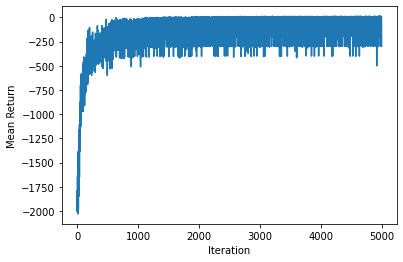

In [ ]:
import torch
import gym
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import random

###  policyGradient  ###
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_num = 700
torch.manual_seed(seed_num)
torch.cuda.manual_seed(seed_num)
torch.cuda.manual_seed_all(seed_num)
np.random.seed(seed_num)
random.seed(seed_num)

class PolicyNet(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_size=64):
        super(PolicyNet, self).__init__()
        self.embedding = torch.nn.Embedding(500, input_size)
        # self.fc1 = torch.nn.Linear(input_size, hidden_layer_size)   # MLP
        self.layer1 = torch.nn.Sequential(
            torch.nn.Linear(input_size, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, hidden_layer_size),
            torch.nn.ReLU()
        )
        # self.fc2 = torch.nn.Linear(hidden_layer_size, output_size)  # MLP

        self.final = torch.nn.Linear(hidden_layer_size, output_size)
        self.softmax = torch.nn.Softmax(dim=0)                      # 소프트맥스 필요, 출력 값이 각 action을 실행할 '확률'이라서

    def forward(self, x):
        # print(x)
        # x = torch.from_numpy(x).float()
        x= torch.LongTensor([x])
        x = self.embedding(x)
        x= x.squeeze(0)

        return self.softmax(self.final(self.layer1(x)))

    def get_action_and_logp(self, x):
        action_prob = self.forward(x)  # action_prob : 각 action을 실행할 '확률'값들에 대한 tensor ,  ex) [0.1, 0.5, 0.2, 0.2]
        m = torch.distributions.Categorical(action_prob)  # Categorical한 대상에 대해 확률분포를 생성함. ex) action_prob=[0.1, 0.5, 0.2, 0.2]라면, 0번째 action을 뽑을 확률 0.1, 1번째 action을 뽑을 확률 0.5

        action = m.sample()                               # 출력값은 tensor(3) or tensor(1), or tensor(0) 등 index로 출력함
        # print(m.sample())                                 # 출력값은 tensor(3) or tensor(1), or tensor(0) 등 index로 출력함
        logp = m.log_prob(action)                         # log_prob은 확률값을 log로 변환시키는 함수 , log(tensor(0))과 동일 즉, log(0번째 action의 확률)과 동일
        # print(logp)                                     # 출력 : tensor(-2.3026)   // np.log(0.1)  = -2.3025850929940455
        return action.item(), logp                        # action_index , log 취한 action 선택 확률

    def act(self, x):
        action, _ = self.get_action_and_logp(x)
        return action

class ValueNet(torch.nn.Module):
    def __init__(self, input_size, hidden_layer_size=64):
        super(ValueNet, self).__init__()
        self.embedding = torch.nn.Embedding(500, input_size)
        self.fc1 = torch.nn.Linear(input_size, hidden_layer_size)
        self.fc2 = torch.nn.Linear(hidden_layer_size, 6)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Linear(input_size, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, hidden_layer_size),
            torch.nn.ReLU()
        )
        self.final = torch.nn.Linear(hidden_layer_size, 6)

    def forward(self, x):
        x= torch.LongTensor([x])
        x = self.embedding(x)
        x= x.squeeze(0)
        return self.final(self.layer1(x))
        # return self.fc2(torch.nn.functional.relu(self.fc1(x)))

def policyGradient(env, max_num_steps=500, gamma=0.98, lr=0.002,
                   num_traj=10, num_iter=200):
    input_size = env.observation_space.n  ## STATE SPACE (STATE의 개수)
    output_size = env.action_space.n             ## ACTION의 개수
    Trajectory = namedtuple('Trajectory', 'states actions rewards dones logp')    # 'Trajectory'에 states actions rewards dones logp 튜플을 할당함


    def collect_trajectory():  # Trajectory 모으는 함수 (1 episode 돌리는 함수)
        state_list = []
        action_list = []
        reward_list = []
        dones_list = []
        logp_list = []
        state = env.reset()
        done = False
        steps = 0
        while not done and steps <= max_num_steps:   # done(에피소드 종료) 될때까지 루프 
            action, logp = policy.get_action_and_logp(state)  # policy = PolicyNet(input_size, output_size)
            newstate, reward, done, _, _ = env.step(action)    # s_, r, terminated, truncated, _
            state_list.append(state)
            action_list.append(action)
            reward_list.append(reward)
            dones_list.append(done)
            logp_list.append(logp)
            steps += 1
            state = newstate

        traj = Trajectory(states=state_list, actions=action_list,
                          rewards=reward_list, logp=logp_list, dones=dones_list)
      # print(traj)  # Trajectory(states=[array([ 9.5363184e-06,  9.3068667e-03,  3.0773466e-02, -4.3019545e-03],
      # dtype=float32), array([ 1.9567365e-04, -1.8624260e-01,  3.0687427e-02,  2.9792932e-01],
      # dtype=float32), array([-0.00352918,  0.00842878,  0.03664601,  0.01508044], dtype=float32), array([-0.0033606 ,  0.20300654,  0.03694762, -0.26581872], dtype=float32), array([ 0.00069953,  0.3975822 ,  0.03163125, -0.54662293], dtype=float32), array([ 0.00865117,  0.5922458 ,  0.02069879, -0.82917416], dtype=float32), array([ 0.02049609,  0.3968471 ,  0.00411531, -0.5300539 ], dtype=float32), array([ 0.02843303,  0.5919109 , -0.00648577, -0.82143724], dtype=float32), array([ 0.04027125,  0.3968783 , -0.02291452, -0.5308013 ], dtype=float32), array([ 0.04820881,  0.59231496, -0.03353054, -0.8306156 ], dtype=float32), array([ 0.06005511,  0.39766696, -0.05014285, -0.54866385], dtype=float32), array([ 0.06800845,  0.20328394, -0.06111613, -0.27219164], dtype=float32), array([ 0.07207413,  0.0090849 , -0.06655996,  0.00060612], dtype=float32), array([ 0.07225583, -0.18502247, -0.06654784,  0.27156827], dtype=float32), array([ 0.06855538, -0.37913483, -0.06111648,  0.5425417 ], dtype=float32), array([ 0.06097268, -0.18320957, -0.05026564,  0.23124543], dtype=float32), array([ 0.05730849,  0.01259326, -0.04564074, -0.07685973], dtype=float32), array([ 0.05756036, -0.1818457 , -0.04717793,  0.20108126], dtype=float32), array([ 0.05392344, -0.37626228, -0.0431563 ,  0.4785165 ], dtype=float32), array([ 0.0463982 , -0.5707492 , -0.03358598,  0.75729126], dtype=float32), array([ 0.03498321, -0.37518087, -0.01844015,  0.45423177], dtype=float32), array([ 0.02747959, -0.5700373 , -0.00935551,  0.7410456 ], dtype=float32), array([ 0.01607885, -0.37478745,  0.0054654 ,  0.44543317], dtype=float32), array([ 0.0085831 , -0.5699863 ,  0.01437406,  0.7398339 ], dtype=float32), array([-0.00281663, -0.76530373,  0.02917074,  1.0370055 ], dtype=float32), array([-0.0181227 , -0.57058144,  0.04991085,  0.75362134], dtype=float32), array([-0.02953433, -0.7663547 ,  0.06498328,  1.0615833 ], dtype=float32), array([-0.04486142, -0.5721506 ,  0.08621494,  0.78998363], dtype=float32), array([-0.05630443, -0.768344  ,  0.10201462,  1.1084964 ], dtype=float32), array([-0.07167131, -0.5746998 ,  0.12418454,  0.8494806 ], dtype=float32), array([-0.08316531, -0.38147032,  0.14117415,  0.59828496], dtype=float32), array([-0.09079471, -0.18857652,  0.15313986,  0.35319027], dtype=float32), array([-0.09456625,  0.00407392,  0.16020367,  0.11244383], dtype=float32), array([-0.09448477,  0.19658096,  0.16245253, -0.12572043], dtype=float32), array([-0.09055315,  0.38904798,  0.15993813, -0.36306855], dtype=float32), array([-0.08277219,  0.58157825,  0.15267676, -0.60135657], dtype=float32), array([-0.07114062,  0.774272  ,  0.14064963, -0.8423221 ], dtype=float32), array([-0.05565519,  0.5775394 ,  0.12380318, -0.50892246], dtype=float32), array([-0.0441044 ,  0.3809106 ,  0.11362474, -0.17993148], dtype=float32), array([-0.03648619,  0.18436155,  0.11002611,  0.14632481], dtype=float32), array([-0.03279895, -0.01214998,  0.1129526 ,  0.47159216], dtype=float32), array([-0.03304195, -0.20867096,  0.12238444,  0.79763263], dtype=float32), array([-0.03721537, -0.01542167,  0.1383371 ,  0.54581815], dtype=float32), array([-0.03752381,  0.17751318,  0.14925346,  0.29972214], dtype=float32), array([-0.03397354, -0.01938604,  0.15524791,  0.6355052 ], dtype=float32), array([-0.03436126,  0.17326893,  0.167958  ,  0.395458  ], dtype=float32), array([-0.03089589,  0.36565927,  0.17586717,  0.16008124], dtype=float32), array([-0.0235827 ,  0.5578845 ,  0.17906879, -0.07237025], dtype=float32), array([-0.01242501,  0.75004774,  0.1776214 , -0.30364075], dtype=float32), array([0.00257595, 0.55289793, 0.17154858, 0.0393778 ], dtype=float32), array([ 0.0136339 ,  0.74519783,  0.17233613, -0.19464979], dtype=float32), array([0.02853786, 0.5480834 , 0.16844313, 0.14705835], dtype=float32), array([ 0.03949953,  0.74044305,  0.1713843 , -0.08810893], dtype=float32), array([0.05430839, 0.54333186, 0.16962212, 0.25336695], dtype=float32), array([0.06517503, 0.73567706, 0.17468946, 0.01861984], dtype=float32), array([ 0.07988857,  0.9279195 ,  0.17506185, -0.21425721], dtype=float32), array([0.09844696, 0.7307833 , 0.17077671, 0.12813324], dtype=float32), array([0.11306263, 0.53367877, 0.17333938, 0.46945378], dtype=float32), array([0.1237362 , 0.33658645, 0.18272845, 0.8113689 ], dtype=float32), array([0.13046794, 0.13949473, 0.19895583, 1.1555083 ], dtype=float32)], actions=[0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1], rewards=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], dones=[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True], logp=[tensor(-0.7011, grad_fn=<SqueezeBackward1>), tensor(-0.4942, grad_fn=<SqueezeBackward1>), tensor(-0.6693, grad_fn=<SqueezeBackward1>), tensor(-0.8719, grad_fn=<SqueezeBackward1>), tensor(-1.0927, grad_fn=<SqueezeBackward1>), tensor(-0.3000, grad_fn=<SqueezeBackward1>), tensor(-1.0943, grad_fn=<SqueezeBackward1>), tensor(-0.2976, grad_fn=<SqueezeBackward1>), tensor(-1.1101, grad_fn=<SqueezeBackward1>), tensor(-0.2912, grad_fn=<SqueezeBackward1>), tensor(-0.3850, grad_fn=<SqueezeBackward1>), tensor(-0.5034, grad_fn=<SqueezeBackward1>), tensor(-0.6458, grad_fn=<SqueezeBackward1>), tensor(-0.8513, grad_fn=<SqueezeBackward1>), tensor(-0.3972, grad_fn=<SqueezeBackward1>), tensor(-0.5714, grad_fn=<SqueezeBackward1>), tensor(-0.6144, grad_fn=<SqueezeBackward1>), tensor(-0.8118, grad_fn=<SqueezeBackward1>), tensor(-1.0638, grad_fn=<SqueezeBackward1>), tensor(-0.2649, grad_fn=<SqueezeBackward1>), tensor(-1.0635, grad_fn=<SqueezeBackward1>), tensor(-0.2634, grad_fn=<SqueezeBackward1>), tensor(-1.0795, grad_fn=<SqueezeBackward1>), tensor(-1.4881, grad_fn=<SqueezeBackward1>), tensor(-0.1490, grad_fn=<SqueezeBackward1>), tensor(-1.5465, grad_fn=<SqueezeBackward1>), tensor(-0.1374, grad_fn=<SqueezeBackward1>), tensor(-1.6341, grad_fn=<SqueezeBackward1>), tensor(-0.1220, grad_fn=<SqueezeBackward1>), tensor(-0.1897, grad_fn=<SqueezeBackward1>), tensor(-0.2872, grad_fn=<SqueezeBackward1>), tensor(-0.4043, grad_fn=<SqueezeBackward1>), tensor(-0.5435, grad_fn=<SqueezeBackward1>), tensor(-0.7004, grad_fn=<SqueezeBackward1>), tensor(-0.9015, grad_fn=<SqueezeBackward1>), tensor(-1.0939, grad_fn=<SqueezeBackward1>), tensor(-0.3111, grad_fn=<SqueezeBackward1>), tensor(-0.4323, grad_fn=<SqueezeBackward1>), tensor(-0.5986, grad_fn=<SqueezeBackward1>), tensor(-0.8267, grad_fn=<SqueezeBackward1>), tensor(-1.1433, grad_fn=<SqueezeBackward1>), tensor(-0.2386, grad_fn=<SqueezeBackward1>), tensor(-0.3441, grad_fn=<SqueezeBackward1>), tensor(-0.9646, grad_fn=<SqueezeBackward1>), tensor(-0.3061, grad_fn=<SqueezeBackward1>), tensor(-0.4233, grad_fn=<SqueezeBackward1>), tensor(-0.5728, grad_fn=<SqueezeBackward1>), tensor(-0.7365, grad_fn=<SqueezeBackward1>), tensor(-0.5085, grad_fn=<SqueezeBackward1>), tensor(-0.6748, grad_fn=<SqueezeBackward1>), tensor(-0.5544, grad_fn=<SqueezeBackward1>), tensor(-0.6252, grad_fn=<SqueezeBackward1>), tensor(-0.6050, grad_fn=<SqueezeBackward1>), tensor(-0.5652, grad_fn=<SqueezeBackward1>), tensor(-0.7268, grad_fn=<SqueezeBackward1>), tensor(-0.5218, grad_fn=<SqueezeBackward1>), tensor(-0.7160, grad_fn=<SqueezeBackward1>), tensor(-1.0044, grad_fn=<SqueezeBackward1>), tensor(-1.3989, grad_fn=<SqueezeBackward1>), tensor(-0.1645, grad_fn=<SqueezeBackward1>)])

        return traj

    def calc_returns(rewards):
        dis_rewards = [gamma**i * r for i, r in enumerate(rewards)]  ## [ gamma**0 * r, gamma**1 * r, gamma**2 * r, gamma**3 * r, ...]
        return [sum(dis_rewards[i:]) for i in range(len(dis_rewards))]  ## [R(0~end), R(1~end), R(2~end), ...]

    policy = PolicyNet(input_size, output_size)
    policy_optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    value = ValueNet(input_size)
    value_optimizer = torch.optim.Adam(value.parameters(), lr=lr)

    mean_return_list = []
    for it in range(num_iter):
        traj_list = [collect_trajectory() for _ in range(num_traj)]    #
        returns = [calc_returns(traj.rewards) for traj in traj_list]   # traj.rewards는 traj(Trajectory에서 tuple 요소중 rewards를 뽑아냄)
                                                                       # returns는 2차원 : [[Return(0~end), Return(1~end), Return(2~end), ...],  [Return(0~end), Return(1~end), Return(2~end), ...], ... , [Return(0~end), Return(1~end), Return(2~end), ...] ]

        # ====================================#
        # policy gradient                    #
        # ====================================#
        # policy_loss_terms = [-1. * traj.logp[j] * (torch.Tensor([returns[i][0]]))                   # returns[i][0] :   Return(0~end)로만 참고함 ([Return(0~end), Return(0~end), Return(0~end), ..., ...])   Expectation of Return이 목적함수(로스 펑션으로 만들기 위해 -1 추가)
        #                     for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]  # policy gradient, policyNet에서의 로스 펑션, 값이 작을수록 Loss가 적은 형태로 식을 만들기 위해 앞에 -1 붙임

        # ====================================#
        # policy gradient with reward-to-go  #
        # ====================================#
        # policy_loss_terms = [-1. * traj.logp[j] * (torch.Tensor([returns[i][j]]))                   # returns[i][j]] :   Return(j~end)로 참고함 => [Return(0~end), Return(1~end), Return(2~end), ~, Return(end-1~end) , ..., ... , ]    Expectation of Return이 목적함수
        #                     for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]  # policy gradient, policyNet에서의 로스 펑션, 값이 작을수록 Loss가 적은 형태로 식을 만들기 위해 앞에 -1 붙임

        #====================================#
        # policy gradient with base function #
        #====================================#
        policy_loss_terms = [-1. * traj.logp[j] * (returns[i][j] - value(traj.states[j]))             # returns[i][j] - value(traj.states[j]  :   리턴값에 대해 표준화 적용 (평균값을 빼줌), 평균값은 곧 기대값이고 V(s)를 통해 구함. V(s)는 ValueNet에서 구함.
                             for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]   # policy gradient, policyNet에서의 로스 펑션, 값이 작을수록 Loss가 적은 형태로 식을 만들기 위해 앞에 -1 붙임


        policy_loss = 1. / num_traj * torch.cat(policy_loss_terms).sum()                              # 각  returns의 원소들을 합산하고 나눔  =>  Expectation of Return 계산
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        value_loss_terms = [1. / len(traj.actions) * (value(traj.states[j]) - returns[i][j])**2.      # ValueNet에서의 로스 펑션, MSE 적용
                            for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]
        value_loss = 1. / num_traj * torch.cat(value_loss_terms).sum()
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

        mean_return = 1. / num_traj * \
            sum([traj_returns[0] for traj_returns in returns])
        mean_return_list.append(mean_return)
        pd.DataFrame(mean_return_list).to_csv('/content/drive/MyDrive/강화학습/policy_gradient_model_record1.csv')

        if it % 10 == 0:
            print('Iteration {}: Mean Return = {}'.format(it, mean_return))
            torch.save(policy.state_dict(), '/content/drive/MyDrive/강화학습/policy_gradient_model1_temp.pth')

    torch.save(policy.state_dict(), '/content/drive/MyDrive/강화학습/policy_gradient_model1_last.pth')

    return policy, mean_return_list

env = gym.make('Taxi-v3').unwrapped
env._max_episode_steps=500
agent, mean_return_list = policyGradient(env, num_iter=5000, max_num_steps=500, gamma=1.0, num_traj=5)


plt.plot(mean_return_list)
plt.xlabel('Iteration')
plt.ylabel('Mean Return')
plt.savefig('pg1_returns.png', format='png', dpi=300)

Iteration 0: Mean Return = -1674.6000000000001
Iteration 10: Mean Return = -2054.4
Iteration 20: Mean Return = -2098.4
Iteration 30: Mean Return = -1976.4
Iteration 40: Mean Return = -1961.8000000000002
Iteration 50: Mean Return = -2236.2000000000003
Iteration 60: Mean Return = -1926.6000000000001
Iteration 70: Mean Return = -1564.2
Iteration 80: Mean Return = -1708.0
Iteration 90: Mean Return = -1324.0
Iteration 100: Mean Return = -1607.6000000000001
Iteration 110: Mean Return = -1351.8000000000002
Iteration 120: Mean Return = -1043.8
Iteration 130: Mean Return = -1257.6000000000001
Iteration 140: Mean Return = -1198.4
Iteration 150: Mean Return = -948.0
Iteration 160: Mean Return = -745.8000000000001
Iteration 170: Mean Return = -981.8000000000001
Iteration 180: Mean Return = -302.2
Iteration 190: Mean Return = -525.6
Iteration 200: Mean Return = -642.6
Iteration 210: Mean Return = -503.8
Iteration 220: Mean Return = -579.8000000000001
Iteration 230: Mean Return = -346.0
Iteration 24

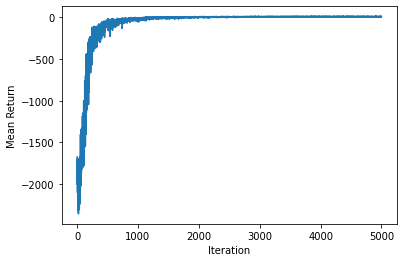

In [ ]:
import torch
import gym
from collections import namedtuple
import matplotlib.pyplot as plt

###  policyGradient  ###
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PolicyNet(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_size=64):
        super(PolicyNet, self).__init__()
        self.embedding = torch.nn.Embedding(500, input_size)
        # self.fc1 = torch.nn.Linear(input_size, hidden_layer_size)   # MLP
        self.layer1 = torch.nn.Sequential(
            torch.nn.Linear(input_size, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, hidden_layer_size),
            torch.nn.ReLU()
        )
        # self.fc2 = torch.nn.Linear(hidden_layer_size, output_size)  # MLP

        self.final = torch.nn.Linear(hidden_layer_size, output_size)
        self.softmax = torch.nn.Softmax(dim=0)                      # 소프트맥스 필요, 출력 값이 각 action을 실행할 '확률'이라서

    def forward(self, x):
        # print(x)
        # x = torch.from_numpy(x).float()
        x= torch.LongTensor([x])
        x = self.embedding(x)
        x= x.squeeze(0)

        return self.softmax(self.final(self.layer1(x)))

    def get_action_and_logp(self, x):
        action_prob = self.forward(x)  # action_prob : 각 action을 실행할 '확률'값들에 대한 tensor ,  ex) [0.1, 0.5, 0.2, 0.2]
        m = torch.distributions.Categorical(action_prob)  # Categorical한 대상에 대해 확률분포를 생성함. ex) action_prob=[0.1, 0.5, 0.2, 0.2]라면, 0번째 action을 뽑을 확률 0.1, 1번째 action을 뽑을 확률 0.5

        action = m.sample()                               # 출력값은 tensor(3) or tensor(1), or tensor(0) 등 index로 출력함
        # print(m.sample())                                 # 출력값은 tensor(3) or tensor(1), or tensor(0) 등 index로 출력함
        logp = m.log_prob(action)                         # log_prob은 확률값을 log로 변환시키는 함수 , log(tensor(0))과 동일 즉, log(0번째 action의 확률)과 동일
        # print(logp)                                     # 출력 : tensor(-2.3026)   // np.log(0.1)  = -2.3025850929940455
        return action.item(), logp                        # action_index , log 취한 action 선택 확률

    def act(self, x):
        action, _ = self.get_action_and_logp(x)
        return action

class ValueNet(torch.nn.Module):
    def __init__(self, input_size, hidden_layer_size=64):
        super(ValueNet, self).__init__()
        self.embedding = torch.nn.Embedding(500, input_size)
        self.fc1 = torch.nn.Linear(input_size, hidden_layer_size)
        self.fc2 = torch.nn.Linear(hidden_layer_size, 6)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Linear(input_size, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, hidden_layer_size),
            torch.nn.ReLU()
        )
        self.final = torch.nn.Linear(hidden_layer_size, 6)

    def forward(self, x):
        x= torch.LongTensor([x])
        x = self.embedding(x)
        x= x.squeeze(0)
        return self.final(self.layer1(x))
        # return self.fc2(torch.nn.functional.relu(self.fc1(x)))

def policyGradient(env, max_num_steps=500, gamma=0.98, lr=0.002,
                   num_traj=10, num_iter=200):
    input_size = env.observation_space.n  ## STATE SPACE (STATE의 개수)
    output_size = env.action_space.n             ## ACTION의 개수
    Trajectory = namedtuple('Trajectory', 'states actions rewards dones logp')    # 'Trajectory'에 states actions rewards dones logp 튜플을 할당함


    def collect_trajectory():  # Trajectory 모으는 함수 (1 episode 돌리는 함수)
        state_list = []
        action_list = []
        reward_list = []
        dones_list = []
        logp_list = []
        state = env.reset()
        done = False
        steps = 0
        while not done and steps <= max_num_steps:   # done(에피소드 종료) 될때까지 루프 
            action, logp = policy.get_action_and_logp(state)  # policy = PolicyNet(input_size, output_size)
            newstate, reward, done, _, _ = env.step(action)    # s_, r, terminated, truncated, _
            state_list.append(state)
            action_list.append(action)
            reward_list.append(reward)
            dones_list.append(done)
            logp_list.append(logp)
            steps += 1
            state = newstate

        traj = Trajectory(states=state_list, actions=action_list,
                          rewards=reward_list, logp=logp_list, dones=dones_list)
      # print(traj)  # Trajectory(states=[array([ 9.5363184e-06,  9.3068667e-03,  3.0773466e-02, -4.3019545e-03],
      # dtype=float32), array([ 1.9567365e-04, -1.8624260e-01,  3.0687427e-02,  2.9792932e-01],
      # dtype=float32), array([-0.00352918,  0.00842878,  0.03664601,  0.01508044], dtype=float32), array([-0.0033606 ,  0.20300654,  0.03694762, -0.26581872], dtype=float32), array([ 0.00069953,  0.3975822 ,  0.03163125, -0.54662293], dtype=float32), array([ 0.00865117,  0.5922458 ,  0.02069879, -0.82917416], dtype=float32), array([ 0.02049609,  0.3968471 ,  0.00411531, -0.5300539 ], dtype=float32), array([ 0.02843303,  0.5919109 , -0.00648577, -0.82143724], dtype=float32), array([ 0.04027125,  0.3968783 , -0.02291452, -0.5308013 ], dtype=float32), array([ 0.04820881,  0.59231496, -0.03353054, -0.8306156 ], dtype=float32), array([ 0.06005511,  0.39766696, -0.05014285, -0.54866385], dtype=float32), array([ 0.06800845,  0.20328394, -0.06111613, -0.27219164], dtype=float32), array([ 0.07207413,  0.0090849 , -0.06655996,  0.00060612], dtype=float32), array([ 0.07225583, -0.18502247, -0.06654784,  0.27156827], dtype=float32), array([ 0.06855538, -0.37913483, -0.06111648,  0.5425417 ], dtype=float32), array([ 0.06097268, -0.18320957, -0.05026564,  0.23124543], dtype=float32), array([ 0.05730849,  0.01259326, -0.04564074, -0.07685973], dtype=float32), array([ 0.05756036, -0.1818457 , -0.04717793,  0.20108126], dtype=float32), array([ 0.05392344, -0.37626228, -0.0431563 ,  0.4785165 ], dtype=float32), array([ 0.0463982 , -0.5707492 , -0.03358598,  0.75729126], dtype=float32), array([ 0.03498321, -0.37518087, -0.01844015,  0.45423177], dtype=float32), array([ 0.02747959, -0.5700373 , -0.00935551,  0.7410456 ], dtype=float32), array([ 0.01607885, -0.37478745,  0.0054654 ,  0.44543317], dtype=float32), array([ 0.0085831 , -0.5699863 ,  0.01437406,  0.7398339 ], dtype=float32), array([-0.00281663, -0.76530373,  0.02917074,  1.0370055 ], dtype=float32), array([-0.0181227 , -0.57058144,  0.04991085,  0.75362134], dtype=float32), array([-0.02953433, -0.7663547 ,  0.06498328,  1.0615833 ], dtype=float32), array([-0.04486142, -0.5721506 ,  0.08621494,  0.78998363], dtype=float32), array([-0.05630443, -0.768344  ,  0.10201462,  1.1084964 ], dtype=float32), array([-0.07167131, -0.5746998 ,  0.12418454,  0.8494806 ], dtype=float32), array([-0.08316531, -0.38147032,  0.14117415,  0.59828496], dtype=float32), array([-0.09079471, -0.18857652,  0.15313986,  0.35319027], dtype=float32), array([-0.09456625,  0.00407392,  0.16020367,  0.11244383], dtype=float32), array([-0.09448477,  0.19658096,  0.16245253, -0.12572043], dtype=float32), array([-0.09055315,  0.38904798,  0.15993813, -0.36306855], dtype=float32), array([-0.08277219,  0.58157825,  0.15267676, -0.60135657], dtype=float32), array([-0.07114062,  0.774272  ,  0.14064963, -0.8423221 ], dtype=float32), array([-0.05565519,  0.5775394 ,  0.12380318, -0.50892246], dtype=float32), array([-0.0441044 ,  0.3809106 ,  0.11362474, -0.17993148], dtype=float32), array([-0.03648619,  0.18436155,  0.11002611,  0.14632481], dtype=float32), array([-0.03279895, -0.01214998,  0.1129526 ,  0.47159216], dtype=float32), array([-0.03304195, -0.20867096,  0.12238444,  0.79763263], dtype=float32), array([-0.03721537, -0.01542167,  0.1383371 ,  0.54581815], dtype=float32), array([-0.03752381,  0.17751318,  0.14925346,  0.29972214], dtype=float32), array([-0.03397354, -0.01938604,  0.15524791,  0.6355052 ], dtype=float32), array([-0.03436126,  0.17326893,  0.167958  ,  0.395458  ], dtype=float32), array([-0.03089589,  0.36565927,  0.17586717,  0.16008124], dtype=float32), array([-0.0235827 ,  0.5578845 ,  0.17906879, -0.07237025], dtype=float32), array([-0.01242501,  0.75004774,  0.1776214 , -0.30364075], dtype=float32), array([0.00257595, 0.55289793, 0.17154858, 0.0393778 ], dtype=float32), array([ 0.0136339 ,  0.74519783,  0.17233613, -0.19464979], dtype=float32), array([0.02853786, 0.5480834 , 0.16844313, 0.14705835], dtype=float32), array([ 0.03949953,  0.74044305,  0.1713843 , -0.08810893], dtype=float32), array([0.05430839, 0.54333186, 0.16962212, 0.25336695], dtype=float32), array([0.06517503, 0.73567706, 0.17468946, 0.01861984], dtype=float32), array([ 0.07988857,  0.9279195 ,  0.17506185, -0.21425721], dtype=float32), array([0.09844696, 0.7307833 , 0.17077671, 0.12813324], dtype=float32), array([0.11306263, 0.53367877, 0.17333938, 0.46945378], dtype=float32), array([0.1237362 , 0.33658645, 0.18272845, 0.8113689 ], dtype=float32), array([0.13046794, 0.13949473, 0.19895583, 1.1555083 ], dtype=float32)], actions=[0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1], rewards=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], dones=[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True], logp=[tensor(-0.7011, grad_fn=<SqueezeBackward1>), tensor(-0.4942, grad_fn=<SqueezeBackward1>), tensor(-0.6693, grad_fn=<SqueezeBackward1>), tensor(-0.8719, grad_fn=<SqueezeBackward1>), tensor(-1.0927, grad_fn=<SqueezeBackward1>), tensor(-0.3000, grad_fn=<SqueezeBackward1>), tensor(-1.0943, grad_fn=<SqueezeBackward1>), tensor(-0.2976, grad_fn=<SqueezeBackward1>), tensor(-1.1101, grad_fn=<SqueezeBackward1>), tensor(-0.2912, grad_fn=<SqueezeBackward1>), tensor(-0.3850, grad_fn=<SqueezeBackward1>), tensor(-0.5034, grad_fn=<SqueezeBackward1>), tensor(-0.6458, grad_fn=<SqueezeBackward1>), tensor(-0.8513, grad_fn=<SqueezeBackward1>), tensor(-0.3972, grad_fn=<SqueezeBackward1>), tensor(-0.5714, grad_fn=<SqueezeBackward1>), tensor(-0.6144, grad_fn=<SqueezeBackward1>), tensor(-0.8118, grad_fn=<SqueezeBackward1>), tensor(-1.0638, grad_fn=<SqueezeBackward1>), tensor(-0.2649, grad_fn=<SqueezeBackward1>), tensor(-1.0635, grad_fn=<SqueezeBackward1>), tensor(-0.2634, grad_fn=<SqueezeBackward1>), tensor(-1.0795, grad_fn=<SqueezeBackward1>), tensor(-1.4881, grad_fn=<SqueezeBackward1>), tensor(-0.1490, grad_fn=<SqueezeBackward1>), tensor(-1.5465, grad_fn=<SqueezeBackward1>), tensor(-0.1374, grad_fn=<SqueezeBackward1>), tensor(-1.6341, grad_fn=<SqueezeBackward1>), tensor(-0.1220, grad_fn=<SqueezeBackward1>), tensor(-0.1897, grad_fn=<SqueezeBackward1>), tensor(-0.2872, grad_fn=<SqueezeBackward1>), tensor(-0.4043, grad_fn=<SqueezeBackward1>), tensor(-0.5435, grad_fn=<SqueezeBackward1>), tensor(-0.7004, grad_fn=<SqueezeBackward1>), tensor(-0.9015, grad_fn=<SqueezeBackward1>), tensor(-1.0939, grad_fn=<SqueezeBackward1>), tensor(-0.3111, grad_fn=<SqueezeBackward1>), tensor(-0.4323, grad_fn=<SqueezeBackward1>), tensor(-0.5986, grad_fn=<SqueezeBackward1>), tensor(-0.8267, grad_fn=<SqueezeBackward1>), tensor(-1.1433, grad_fn=<SqueezeBackward1>), tensor(-0.2386, grad_fn=<SqueezeBackward1>), tensor(-0.3441, grad_fn=<SqueezeBackward1>), tensor(-0.9646, grad_fn=<SqueezeBackward1>), tensor(-0.3061, grad_fn=<SqueezeBackward1>), tensor(-0.4233, grad_fn=<SqueezeBackward1>), tensor(-0.5728, grad_fn=<SqueezeBackward1>), tensor(-0.7365, grad_fn=<SqueezeBackward1>), tensor(-0.5085, grad_fn=<SqueezeBackward1>), tensor(-0.6748, grad_fn=<SqueezeBackward1>), tensor(-0.5544, grad_fn=<SqueezeBackward1>), tensor(-0.6252, grad_fn=<SqueezeBackward1>), tensor(-0.6050, grad_fn=<SqueezeBackward1>), tensor(-0.5652, grad_fn=<SqueezeBackward1>), tensor(-0.7268, grad_fn=<SqueezeBackward1>), tensor(-0.5218, grad_fn=<SqueezeBackward1>), tensor(-0.7160, grad_fn=<SqueezeBackward1>), tensor(-1.0044, grad_fn=<SqueezeBackward1>), tensor(-1.3989, grad_fn=<SqueezeBackward1>), tensor(-0.1645, grad_fn=<SqueezeBackward1>)])

        return traj

    def calc_returns(rewards):
        dis_rewards = [gamma**i * r for i, r in enumerate(rewards)]  ## [ gamma**0 * r, gamma**1 * r, gamma**2 * r, gamma**3 * r, ...]
        return [sum(dis_rewards[i:]) for i in range(len(dis_rewards))]  ## [R(0~end), R(1~end), R(2~end), ...]

    policy = PolicyNet(input_size, output_size)
    policy_optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

    value = ValueNet(input_size)
    value_optimizer = torch.optim.Adam(value.parameters(), lr=lr)

    mean_return_list = []
    for it in range(num_iter):
        traj_list = [collect_trajectory() for _ in range(num_traj)]    #
        returns = [calc_returns(traj.rewards) for traj in traj_list]   # traj.rewards는 traj(Trajectory에서 tuple 요소중 rewards를 뽑아냄)
                                                                       # returns는 2차원 : [[Return(0~end), Return(1~end), Return(2~end), ...],  [Return(0~end), Return(1~end), Return(2~end), ...], ... , [Return(0~end), Return(1~end), Return(2~end), ...] ]

        # ====================================#
        # policy gradient                    #
        # ====================================#
        # policy_loss_terms = [-1. * traj.logp[j] * (torch.Tensor([returns[i][0]]))                   # returns[i][0] :   Return(0~end)로만 참고함 ([Return(0~end), Return(0~end), Return(0~end), ..., ...])   Expectation of Return이 목적함수(로스 펑션으로 만들기 위해 -1 추가)
        #                     for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]  # policy gradient, policyNet에서의 로스 펑션, 값이 작을수록 Loss가 적은 형태로 식을 만들기 위해 앞에 -1 붙임

        # ====================================#
        # policy gradient with reward-to-go  #
        # ====================================#
        # policy_loss_terms = [-1. * traj.logp[j] * (torch.Tensor([returns[i][j]]))                   # returns[i][j]] :   Return(j~end)로 참고함 => [Return(0~end), Return(1~end), Return(2~end), ~, Return(end-1~end) , ..., ... , ]    Expectation of Return이 목적함수
        #                     for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]  # policy gradient, policyNet에서의 로스 펑션, 값이 작을수록 Loss가 적은 형태로 식을 만들기 위해 앞에 -1 붙임

        #====================================#
        # policy gradient with base function #
        #====================================#
        policy_loss_terms = [-1. * traj.logp[j] * (returns[i][j] - value(traj.states[j]))             # returns[i][j] - value(traj.states[j]  :   리턴값에 대해 표준화 적용 (평균값을 빼줌), 평균값은 곧 기대값이고 V(s)를 통해 구함. V(s)는 ValueNet에서 구함.
                             for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]   # policy gradient, policyNet에서의 로스 펑션, 값이 작을수록 Loss가 적은 형태로 식을 만들기 위해 앞에 -1 붙임


        policy_loss = 1. / num_traj * torch.cat(policy_loss_terms).sum()                              # 각  returns의 원소들을 합산하고 나눔  =>  Expectation of Return 계산
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        value_loss_terms = [1. / len(traj.actions) * (value(traj.states[j]) - returns[i][j])**2.      # ValueNet에서의 로스 펑션, MSE 적용
                            for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]
        value_loss = 1. / num_traj * torch.cat(value_loss_terms).sum()
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

        mean_return = 1. / num_traj * \
            sum([traj_returns[0] for traj_returns in returns])
        mean_return_list.append(mean_return)
        pd.DataFrame(mean_return_list).to_csv('/content/drive/MyDrive/강화학습/policy_gradient_model_record.csv')

        if it % 10 == 0:
            print('Iteration {}: Mean Return = {}'.format(it, mean_return))
            torch.save(policy.state_dict(), '/content/drive/MyDrive/강화학습/policy_gradient_model_temp.pth')

    torch.save(policy.state_dict(), '/content/drive/MyDrive/강화학습/policy_gradient_model_last.pth')

    return policy, mean_return_list

env = gym.make('Taxi-v3').unwrapped
env._max_episode_steps=500
agent, mean_return_list = policyGradient(env, num_iter=5000, max_num_steps=500, gamma=1.0, num_traj=5)


plt.plot(mean_return_list)
plt.xlabel('Iteration')
plt.ylabel('Mean Return')
plt.savefig('pg1_returns.png', format='png', dpi=300)

# Policy Gradient Metric

In [ ]:
metric_random = pd.read_csv('/content/drive/MyDrive/강화학습/policy_gradient_model_record.csv', index_col = 0).rename(columns = {'0':'return'})
metric_700 = pd.read_csv('/content/drive/MyDrive/강화학습/policy_gradient_model_record1_seed700.csv', index_col = 0).rename(columns = {'0':'return'})
metric_2022 = pd.read_csv('/content/drive/MyDrive/강화학습/policy_gradient_model_record2_seed2022.csv', index_col = 0).rename(columns = {'0':'return'})

In [ ]:
metric_random.iloc[-100:].describe()

,return
count,100.000000
mean,7.160000
std,1.427578
min,4.000000
25%,6.200000
50%,7.200000
75%,8.000000
max,10.800000


In [ ]:
metric_700.iloc[-100:].describe()

,return
count,100.000000
mean,-117.246000
std,99.267804
min,-501.000000
25%,-195.400000
50%,-94.400000
75%,-67.000000
max,10.200000


In [ ]:
metric_2022.iloc[-100:].describe()

,return
count,100.000000
mean,-1.134000
std,27.592036
min,-95.800000
25%,5.600000
50%,6.800000
75%,7.800000
max,11.400000


# Double DQN (Fail & Trial)

In [ ]:
# libraries
import gym
import collections
import random
import pandas as pd

# pytorch library is used for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# hyperparameters
learning_rate = 0.002
gamma = 0.98
buffer_limit = 200000        # size of replay buffer, 버퍼에 저장할 데이터 개수
batch_size = 1024

EPS_START = 0.9
EPS_END = 0.001
MAX_EPISODE = 500

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)    # double-ended queue(deque)를 저장소로 선택,
                                                                # buffer_size는 50000으로 설정,
                                                                # 50000개가 차면 그 이후부터는 가장 오래된 데이터를 삭제하고 새 데이터를 보관
    
    def put(self, transition):  # transition 데이터 넣기 메소드
        self.buffer.append(transition)

    def sample(self, n):     # transition 데이터 추출 메소드 (train할떄 batch만들듯이 random으로 데이터 추출해감)
        mini_batch = random.sample(self.buffer, n)  # n개만큼 데이터 추출
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], [] # (s,a,r,s')과 종료여부

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition  # buffer에서 추출된 mini_batch에서 transition 데이터 추출
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)

    def size(self):  # buffer의 사이즈 확인하는 용도의 메소드
        return len(self.buffer)


class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__() # 초기화
        self.embedding = torch.nn.Embedding(500, 500)
        self.fc1 = nn.Linear(500, 128)  # 가중치 3개(히든 레이어 2개 적용) 입력값(state)은 4개 (cart position, cart 속도, pole 각도, pole 속도)
        self.fc2 = nn.Linear(128, 64) # 가중치 3개(히든 레이어 2개 적용)
        self.fc3 = nn.Linear(64, 6) # 가중치 3개(히든 레이어 2개 적용), output(Q(s,a))은 2개
        self.softmax = torch.nn.Softmax(dim=0)

    def forward(self, x):
        x = self.embedding(x.long())
        x= x.squeeze(0)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def prob_sample_action(self, obs):  # epsilon-greedy로 action 선택하는 함수,  obs : state input 값
        out = self.forward(obs)  # forward를 진행 (신경망 통과), out은 tensor 형태
        action_prob = self.softmax(out)
        m = torch.distributions.Categorical(action_prob)
        action = m.sample()
        return action.item()   

    def sample_action(self, obs, epsilon):  # epsilon-greedy로 action 선택하는 함수,  obs : state input 값
        out = self.forward(obs)  # forward를 진행 (신경망 통과), out은 tensor 형태
        # print(out, out.argmax())
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,5)
        else : 
            return out.argmax().item()   

def train(q, q_target, memory, optimizer):
    for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)  # memory에서 데이터 sampling(추출하기), 배치 사이즈만큼

        q_out = q(s)  # q_out.shape = (batch_size, 2)  // 2는 액션의 개수
        q_a = q_out.gather(1,a)  # action_list인 a를 활용하여, Q테이블에서 각 state에 맞는 action 값을 취함.
                                  # => 그에 대한 value 값을 q_a에 텐서로 저장

        # DQN
        # max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)  # 타겟넷에 대한 output 값에 대해 dim=1의 max값을 취함

        # Double DQN
        argmax_Q = q(s_prime).max(1)[1].unsqueeze(1)
        max_q_prime = q_target(s_prime).gather(1, argmax_Q)

        target = r + gamma * max_q_prime * done_mask # terminate stae면 done_mask가 0이므로 뒤의 항 없어짐
        
        # MSE Loss
        loss = F.mse_loss(q_a, target)

        # Smooth L1 Loss
        #loss = F.smooth_l1_loss(q_a, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def epsilon_annealing(episode, max_episode, min_eps, max_eps):
    if max_episode == 0:
        return min_eps
    slope = (min_eps - max_eps) / max_episode
    return max(slope * episode + max_eps, min_eps)

def main():
    env = gym.make('Taxi-v3').unwrapped
    q = Qnet()            # 메인 넷
    q_target = Qnet()     # 타겟 넷  , 별개로 학습
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()  ## transition을 담고 있는 테이블에 대한 객체 선언

    print_interval = 20   #
    score = 0.0           #
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)
    # boost = 1 

    return_list = []
    for n_epi in range(5000):
        # epsilon = max(0.01, 0.5 - 0.02*(n_epi/200)*boost) #Linear annealing from 8% to 1%, epsilon 값을 0.01이 되기 전까지 점점 줄여가도록 함.
        epsilon = epsilon_annealing(n_epi, MAX_EPISODE, EPS_END, EPS_START)
        s = env.reset()
        done = False

        if n_epi > 500:
          boost = 5
        

        for i in range(15000):  # 200step으로 제한
        # while not done:
            if n_epi > 1000:
              a = q.sample_action(torch.LongTensor([s]), epsilon)  # action을 policy(eplsilon-grredy)에 따라 선택

            else:
              a = q.prob_sample_action(torch.LongTensor([s]))
              # print(s, a)

            # a = random.randint(0,5)
            s_prime, r, done, info, _ = env.step(a)  # 단계 진행
            # print(s_prime, a, done)
            # print(s, a, s_prime, r, done)
            done_mask = 0.0 if done else 1.0
            memory.put((s,a,r,s_prime, done_mask))  # r값이 너무 크면, train이 잘 안되서 줄엿음 (왜? 튜닝/테크닉의 영역이라는 교수님의 말씀)
                                                          # replace_buffer 객체에 transition 데이터 저장
            s = s_prime

            score += r
            if done:
                return_list.append(score)
                break

        if memory.size()>20000:  # 메모리 사이즈가 2000까지 차기 전에는 train(x), 데이터가 적을때는 훈련이 무의미하므로
            print('train', n_epi)
            train(q, q_target, memory, optimizer)

        print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(n_epi, score, memory.size(), epsilon*100))
        score = 0.0

        # if n_epi%print_interval==0 and n_epi!=0:  # 20번쨰 episode마다 메인넷(q)의 가중치값을 타겟넷(q_target)으로 카피함.
        #     q_target.load_state_dict(q.state_dict())
        #     print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
        #                                                     n_epi, score/print_interval, memory.size(), epsilon*100))
        #     score = 0.0

        
        pd.DataFrame(return_list).to_csv('Double_DQN_model_record2.csv')
        torch.save(q.state_dict(), 'Double_DQN_model_last2.pth')

    env.close()

if __name__ == '__main__':
    main()

n_episode :0, score : -3460.0, n_buffer : 988, eps : 90.0%
n_episode :1, score : -3477.0, n_buffer : 2002, eps : 89.8%
n_episode :2, score : -52140.0, n_buffer : 16417, eps : 89.6%
n_episode :3, score : -3049.0, n_buffer : 17291, eps : 89.5%
train 4
n_episode :4, score : -39063.0, n_buffer : 28268, eps : 89.3%
train 5
n_episode :5, score : -26999.0, n_buffer : 40321, eps : 89.1%
train 6
n_episode :6, score : -878.0, n_buffer : 41202, eps : 88.9%
train 7
n_episode :7, score : -17466.0, n_buffer : 56202, eps : 88.7%
train 8
n_episode :8, score : -17286.0, n_buffer : 71202, eps : 88.6%
train 9
n_episode :9, score : -15990.0, n_buffer : 86202, eps : 88.4%
train 10
n_episode :10, score : -9115.0, n_buffer : 94681, eps : 88.2%
train 11
n_episode :11, score : -9563.0, n_buffer : 104211, eps : 88.0%
train 12
n_episode :12, score : -15018.0, n_buffer : 119211, eps : 87.8%
train 13
n_episode :13, score : -8909.0, n_buffer : 128123, eps : 87.7%
train 14
n_episode :14, score : -15036.0, n_buffer :

KeyboardInterrupt: ignored

In [ ]:
import gym
import math
import time
import os
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('Taxi-v3').unwrapped

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

LEARNING_RATE = 0.01
NUM_EPISODES = 5000
MEMORY = 200000
BATCH_SIZE = 1024
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.001
MAX_EPISODE = 150
TARGET_UPDATE = 3
HIDDEN_DIM = 64
N_ACTIONS = env.action_space.n
N_STATES = env.observation_space.n

SOLVE_TAXI_MESSAGE = """Task : \n
1) The cab(YELLOW) should find the shortest path to BLUE(passenger) 
2) Perform a "pickup" action to board the passenger which turns the cab(GREEN)
3) Take the passenger to the PINK(drop location) using the shortest path
4) Perform a "dropoff" action
"""


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


class DQN(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(DQN, self).__init__()

        self.embedding = nn.Embedding(input_dim, hidden_dim)

        self.layer1 = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.PReLU()
        )

        self.layer2 = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.PReLU()
        )

        self.final = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)[:,0,:]
        x = self.layer1(x)
        # x = self.layer2(x)
        x = self.final(x)
        return x

policy_net = DQN(N_STATES,N_ACTIONS,HIDDEN_DIM).to(device)
# policy_net.load_state_dict(torch.load('/content/double_dqn_model_last.pth'))
target_net = DQN(N_STATES,N_ACTIONS,HIDDEN_DIM).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)

memory = ReplayMemory(MEMORY)


def to_variable(x, type=torch.long):
    return torch.autograd.Variable(torch.tensor(x, dtype=type).to(device))

def get_Q(net, state):
    state = to_variable(np.array(state).reshape(-1, 1))
    net.train(mode=False)
    return net(state)


def get_action(state, eps):
    if np.random.rand() < eps:
        return np.random.choice(N_ACTIONS)
    else:
        policy_net.train(mode=False)
        scores = get_Q(policy_net, state)
        _, argmax = torch.max(scores.data, 1)
        return int(argmax.cpu().numpy())



episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())


def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    states = np.vstack([x.state for x in transitions])
    actions = np.array([x.action for x in transitions])
    rewards = np.array([x.reward for x in transitions])
    next_states = np.vstack([x.next_state for x in transitions])
    done = np.array([x.done for x in transitions])

    Q_predict = get_Q(policy_net, states)
    
    Q_target = Q_predict.clone().data.cpu().numpy()

    # For DQN
    # Q_target[np.arange(len(Q_target)), actions] = rewards + GAMMA * np.max(get_Q(target_net, next_states).data.cpu().numpy(), axis=1) * ~done

    # For Double DQN
    Q_next_state = np.argmax(get_Q(policy_net, next_states).data.cpu().numpy(), axis=1).reshape(-1)
    Q_target[np.arange(len(Q_target)), actions] = rewards + GAMMA * np.choose(Q_next_state, get_Q(target_net, next_states).data.cpu().numpy().T) * ~done

    Q_target = to_variable(Q_target, type=torch.float)


    policy_net.train(mode=True)
    optim.zero_grad()
    loss = loss_fn(Q_predict, Q_target)
    loss.backward()
    optim.step()

def epsilon_annealing(episode, max_episode, min_eps, max_eps):
    if max_episode == 0:
        return min_eps
    slope = (min_eps - max_eps) / max_episode
    return max(slope * episode + max_eps, min_eps)

def clear_screen(delay=1):
    time.sleep(delay)
    os.system('clear')

def log_progress(env, reward=0, total_reward=0, delay=None, message=None, eps=0):
    if type(message) is str:
        print(message)
    # env.render()
    print('Reward:', reward)
    print('Cumulative reward', total_reward)
    print('ε-greedy probability', eps)
    clear_screen(delay)

def init_message(attempt, perf):
    return 'Initial State : {}'.format(perf_message(attempt=attempt, perf=perf))

def perf_message(attempt, perf):
    return '{}\nAttempt: {} | Average reward (until last episode): {:.2f}'.format(
        SOLVE_TAXI_MESSAGE, 
        attempt + 1, 
        perf
    )


perf = 0
perf_list = []
score  = 0
for i_episode in range(NUM_EPISODES):
    clear_screen(0)
    state = env.reset()
    total_reward = 0
    eps = epsilon_annealing(i_episode, MAX_EPISODE, EPS_END, EPS_START)
    done = False
    t = 0
    log_progress(env, delay=0.5, message=init_message(i_episode, perf), eps=eps)
    while not done:
        action = get_action(state, eps)
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward

        if i_episode >= 250:
            log_progress(env, reward=reward, total_reward=total_reward, delay=0.5,message=perf_message(i_episode, perf), eps=eps)

        memory.push(state, action, next_state, reward, done)

        state = next_state

        optimize_model()
        t += 1

        if done:
            episode_durations.append(t)
            # plot_durations()

    score += total_reward
    perf = score/(i_episode + 1)
    perf_list.append(perf)
    pd.DataFrame(perf_list).to_csv('record.csv')
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        torch.save(policy_net.state_dict(), 'double_dqn_model_temp.pth')

torch.save(policy_net.state_dict(), 'double_dqn_model_last.pth')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
4) Perform a "dropoff" action

Attempt: 4968 | Average reward (until last episode): -31.08
Reward: -1
Cumulative reward -8
ε-greedy probability 0.001
Task : 

1) The cab(YELLOW) should find the shortest path to BLUE(passenger) 
2) Perform a "pickup" action to board the passenger which turns the cab(GREEN)
3) Take the passenger to the PINK(drop location) using the shortest path
4) Perform a "dropoff" action

Attempt: 4968 | Average reward (until last episode): -31.08
Reward: -1
Cumulative reward -9
ε-greedy probability 0.001
Task : 

1) The cab(YELLOW) should find the shortest path to BLUE(passenger) 
2) Perform a "pickup" action to board the passenger which turns the cab(GREEN)
3) Take the passenger to the PINK(drop location) using the shortest path
4) Perform a "dropoff" action

Attempt: 4968 | Average reward (until last episode): -31.08
Reward: -1
Cumulative reward -10
ε-greedy probability 0.001
Task : 

1) The cab(YELLOW) should find the shortest 

In [5]:
# libraries
import gym
import collections
import random
import pandas as pd

# pytorch library is used for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# hyperparameters
learning_rate = 0.002
gamma = 0.98
buffer_limit = 200000        # size of replay buffer, 버퍼에 저장할 데이터 개수
batch_size = 1024

EPS_START = 0.9
EPS_END = 0.001
MAX_EPISODE = 500

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)    # double-ended queue(deque)를 저장소로 선택,
                                                                # buffer_size는 50000으로 설정,
                                                                # 50000개가 차면 그 이후부터는 가장 오래된 데이터를 삭제하고 새 데이터를 보관
    
    def put(self, transition):  # transition 데이터 넣기 메소드
        self.buffer.append(transition)

    def sample(self, n):     # transition 데이터 추출 메소드 (train할떄 batch만들듯이 random으로 데이터 추출해감)
        mini_batch = random.sample(self.buffer, n)  # n개만큼 데이터 추출
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], [] # (s,a,r,s')과 종료여부

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition  # buffer에서 추출된 mini_batch에서 transition 데이터 추출
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)

    def size(self):  # buffer의 사이즈 확인하는 용도의 메소드
        return len(self.buffer)


class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__() # 초기화
        self.embedding = torch.nn.Embedding(500, 500)
        self.fc1 = nn.Linear(500, 128)  # 가중치 3개(히든 레이어 2개 적용) 입력값(state)은 4개 (cart position, cart 속도, pole 각도, pole 속도)
        self.fc2 = nn.Linear(128, 64) # 가중치 3개(히든 레이어 2개 적용)
        self.fc3 = nn.Linear(64, 6) # 가중치 3개(히든 레이어 2개 적용), output(Q(s,a))은 2개

    def forward(self, x):
        x = self.embedding(x.long())
        x= x.squeeze(0)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def sample_action(self, obs, epsilon):  # epsilon-greedy로 action 선택하는 함수,  obs : state input 값
        out = self.forward(obs)  # forward를 진행 (신경망 통과), out은 tensor 형태
        # print(out, out.argmax())
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,5)
        else : 
            return out.argmax().item()   

def train(q, q_target, memory, optimizer):
    for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)  # memory에서 데이터 sampling(추출하기), 배치 사이즈만큼

        q_out = q(s)  # q_out.shape = (batch_size, 2)  // 2는 액션의 개수
        q_a = q_out.gather(1,a)  # action_list인 a를 활용하여, Q테이블에서 각 state에 맞는 action 값을 취함.
                                  # => 그에 대한 value 값을 q_a에 텐서로 저장

        # DQN
        # max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)  # 타겟넷에 대한 output 값에 대해 dim=1의 max값을 취함

        # Double DQN
        argmax_Q = q(s_prime).max(1)[1].unsqueeze(1)
        max_q_prime = q_target(s_prime).gather(1, argmax_Q)

        target = r + gamma * max_q_prime * done_mask # terminate stae면 done_mask가 0이므로 뒤의 항 없어짐
        
        # MSE Loss
        loss = F.mse_loss(q_a, target)

        # Smooth L1 Loss
        #loss = F.smooth_l1_loss(q_a, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def epsilon_annealing(episode, max_episode, min_eps, max_eps):
    if max_episode == 0:
        return min_eps
    slope = (min_eps - max_eps) / max_episode
    return max(slope * episode + max_eps, min_eps)

def main():
    env = gym.make('Taxi-v3').unwrapped
    q = Qnet()            # 메인 넷
    q_target = Qnet()     # 타겟 넷  , 별개로 학습
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()  ## transition을 담고 있는 테이블에 대한 객체 선언

    print_interval = 20   #
    score = 0.0           #
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)
    # boost = 1 

    return_list = []
    for n_epi in range(5000):
        # epsilon = max(0.01, 0.5 - 0.02*(n_epi/200)*boost) #Linear annealing from 8% to 1%, epsilon 값을 0.01이 되기 전까지 점점 줄여가도록 함.
        epsilon = epsilon_annealing(n_epi, MAX_EPISODE, EPS_END, EPS_START)
        s = env.reset()
        done = False

        if n_epi > 500:
          boost = 5
        
        for i in range(15000):  # 200step으로 제한
        # while not done:
            a = q.sample_action(torch.LongTensor([s]), epsilon)  # action을 policy(eplsilon-grredy)에 따라 선택

            # a = random.randint(0,5)
            s_prime, r, done, info, _ = env.step(a)  # 단계 진행
            # print(s_prime, a, done)
            # print(s, a, s_prime, r, done)
            done_mask = 0.0 if done else 1.0
            memory.put((s,a,r,s_prime, done_mask))  # r값이 너무 크면, train이 잘 안되서 줄엿음 (왜? 튜닝/테크닉의 영역이라는 교수님의 말씀)
                                                          # replace_buffer 객체에 transition 데이터 저장
            s = s_prime

            score += r
            if done:
                return_list.append(score)
                break

        if memory.size()>20000:  # 메모리 사이즈가 2000까지 차기 전에는 train(x), 데이터가 적을때는 훈련이 무의미하므로
            print('train', n_epi)
            train(q, q_target, memory, optimizer)

        print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(n_epi, score, memory.size(), epsilon*100))
        score = 0.0

        # if n_epi%print_interval==0 and n_epi!=0:  # 20번쨰 episode마다 메인넷(q)의 가중치값을 타겟넷(q_target)으로 카피함.
        #     q_target.load_state_dict(q.state_dict())
        #     print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
        #                                                     n_epi, score/print_interval, memory.size(), epsilon*100))
        #     score = 0.0

        
        pd.DataFrame(return_list).to_csv('/content/drive/MyDrive/강화학습/Double_DQN_model_record2.csv')
        torch.save(q.state_dict(), '/content/drive/MyDrive/강화학습/Double_DQN_model_last2.pth')

    env.close()

if __name__ == '__main__':
    main()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
train 81
n_episode :81, score : -3668.0, n_buffer : 200000, eps : 75.4%
train 82
n_episode :82, score : -31869.0, n_buffer : 200000, eps : 75.3%
train 83
n_episode :83, score : -21058.0, n_buffer : 200000, eps : 75.1%
train 84
n_episode :84, score : -6937.0, n_buffer : 200000, eps : 74.9%
train 85
n_episode :85, score : -48705.0, n_buffer : 200000, eps : 74.7%
train 86
n_episode :86, score : -24988.0, n_buffer : 200000, eps : 74.5%
train 87
n_episode :87, score : -29115.0, n_buffer : 200000, eps : 74.4%
train 88
n_episode :88, score : -482.0, n_buffer : 200000, eps : 74.2%
train 89
n_episode :89, score : -46689.0, n_buffer : 200000, eps : 74.0%
train 90
n_episode :90, score : -48138.0, n_buffer : 200000, eps : 73.8%
train 91
n_episode :91, score : -14802.0, n_buffer : 200000, eps : 73.6%
train 92
n_episode :92, score : -11513.0, n_buffer : 200000, eps : 73.5%
train 93
n_episode :93, score : -4813.0, n_buffer : 200000, eps : 73.3%
train 94
n_episode :

KeyboardInterrupt: ignored

In [3]:
# libraries
import gym
import collections
import random
import pandas as pd

# pytorch library is used for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# hyperparameters
learning_rate = 0.002
gamma = 0.98
buffer_limit = 200000        # size of replay buffer, 버퍼에 저장할 데이터 개수
batch_size = 1024

EPS_START = 0.9
EPS_END = 0.001
MAX_EPISODE = 500

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)    # double-ended queue(deque)를 저장소로 선택,
                                                                # buffer_size는 50000으로 설정,
                                                                # 50000개가 차면 그 이후부터는 가장 오래된 데이터를 삭제하고 새 데이터를 보관
    
    def put(self, transition):  # transition 데이터 넣기 메소드
        self.buffer.append(transition)

    def sample(self, n):     # transition 데이터 추출 메소드 (train할떄 batch만들듯이 random으로 데이터 추출해감)
        mini_batch = random.sample(self.buffer, n)  # n개만큼 데이터 추출
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], [] # (s,a,r,s')과 종료여부

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition  # buffer에서 추출된 mini_batch에서 transition 데이터 추출
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)

    def size(self):  # buffer의 사이즈 확인하는 용도의 메소드
        return len(self.buffer)


class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__() # 초기화
        self.embedding = torch.nn.Embedding(500, 500)
        self.fc1 = nn.Linear(500, 128)  # 가중치 3개(히든 레이어 2개 적용) 입력값(state)은 4개 (cart position, cart 속도, pole 각도, pole 속도)
        self.fc2 = nn.Linear(128, 64) # 가중치 3개(히든 레이어 2개 적용)
        self.fc3 = nn.Linear(64, 6) # 가중치 3개(히든 레이어 2개 적용), output(Q(s,a))은 2개

    def forward(self, x):
        x = self.embedding(x.long())
        x= x.squeeze(0)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def sample_action(self, obs, epsilon):  # epsilon-greedy로 action 선택하는 함수,  obs : state input 값
        out = self.forward(obs)  # forward를 진행 (신경망 통과), out은 tensor 형태
        # print(out, out.argmax())
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,5)
        else : 
            return out.argmax().item()   

def train(q, q_target, memory, optimizer):
    for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)  # memory에서 데이터 sampling(추출하기), 배치 사이즈만큼

        q_out = q(s)  # q_out.shape = (batch_size, 2)  // 2는 액션의 개수
        q_a = q_out.gather(1,a)  # action_list인 a를 활용하여, Q테이블에서 각 state에 맞는 action 값을 취함.
                                  # => 그에 대한 value 값을 q_a에 텐서로 저장

        # DQN
        # max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)  # 타겟넷에 대한 output 값에 대해 dim=1의 max값을 취함

        # Double DQN
        argmax_Q = q(s_prime).max(1)[1].unsqueeze(1)
        max_q_prime = q_target(s_prime).gather(1, argmax_Q)

        target = r + gamma * max_q_prime * done_mask # terminate stae면 done_mask가 0이므로 뒤의 항 없어짐
        
        # MSE Loss
        loss = F.mse_loss(q_a, target)

        # Smooth L1 Loss
        #loss = F.smooth_l1_loss(q_a, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def epsilon_annealing(episode, max_episode, min_eps, max_eps):
    if max_episode == 0:
        return min_eps
    slope = (min_eps - max_eps) / max_episode
    return max(slope * episode + max_eps, min_eps)

def main():
    env = gym.make('Taxi-v3').unwrapped
    q = Qnet()            # 메인 넷
    q_target = Qnet()     # 타겟 넷  , 별개로 학습
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()  ## transition을 담고 있는 테이블에 대한 객체 선언

    print_interval = 20   #
    score = 0.0           #
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)
    # boost = 1 

    return_list = []
    for n_epi in range(5000):
        # epsilon = max(0.01, 0.5 - 0.02*(n_epi/200)*boost) #Linear annealing from 8% to 1%, epsilon 값을 0.01이 되기 전까지 점점 줄여가도록 함.
        epsilon = epsilon_annealing(n_epi, MAX_EPISODE, EPS_END, EPS_START)
        s = env.reset()
        done = False

        if n_epi > 500:
          boost = 5
        
        for i in range(15000):  # 200step으로 제한
        # while not done:
            a = q.sample_action(torch.LongTensor([s]), epsilon)  # action을 policy(eplsilon-grredy)에 따라 선택

            # a = random.randint(0,5)
            s_prime, r, done, info, _ = env.step(a)  # 단계 진행
            print(s_prime, a, done)
            # print(s, a, s_prime, r, done)
            done_mask = 0.0 if done else 1.0
            memory.put((s,a,r,s_prime, done_mask))  # r값이 너무 크면, train이 잘 안되서 줄엿음 (왜? 튜닝/테크닉의 영역이라는 교수님의 말씀)
                                                          # replace_buffer 객체에 transition 데이터 저장
            s = s_prime

            score += r
            if done:
                return_list.append(score)
                break

        if memory.size()>20000:  # 메모리 사이즈가 2000까지 차기 전에는 train(x), 데이터가 적을때는 훈련이 무의미하므로
            print('train', n_epi)
            train(q, q_target, memory, optimizer)

        print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(n_epi, score, memory.size(), epsilon*100))
        score = 0.0

        # if n_epi%print_interval==0 and n_epi!=0:  # 20번쨰 episode마다 메인넷(q)의 가중치값을 타겟넷(q_target)으로 카피함.
        #     q_target.load_state_dict(q.state_dict())
        #     print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
        #                                                     n_epi, score/print_interval, memory.size(), epsilon*100))
        #     score = 0.0

        
        # pd.DataFrame(return_list).to_csv('/content/drive/MyDrive/강화학습/Double_DQN_model_record2.csv')
        # torch.save(q.state_dict(), '/content/drive/MyDrive/강화학습/Double_DQN_model_last2.pth')

    env.close()

if __name__ == '__main__':
    main()

AttributeError: ignored

# DDPG (Swimmer)

Step 0	 score: 4.45	Average Q: 0.00
Step 10	 score: 24.94	Average Q: 0.18
Step 20	 score: 25.94	Average Q: 2.15
Step 30	 score: 24.46	Average Q: 4.33
Step 40	 score: 14.11	Average Q: 8.46
Step 50	 score: 31.87	Average Q: 6.41
Step 60	 score: 23.70	Average Q: 6.24
Step 70	 score: 23.96	Average Q: 5.24
Step 80	 score: 31.11	Average Q: 4.89
Step 90	 score: 34.91	Average Q: 4.82
Step 100	 score: 37.54	Average Q: 5.08
Step 110	 score: 32.10	Average Q: 4.94
Step 120	 score: 39.51	Average Q: 4.56
Step 130	 score: 31.78	Average Q: 7.04
Step 140	 score: 31.68	Average Q: 6.91
Step 150	 score: 36.00	Average Q: 7.26
Step 160	 score: 37.86	Average Q: 6.93
Step 170	 score: 33.64	Average Q: 7.44
Step 180	 score: 33.96	Average Q: 6.98
Step 190	 score: 35.49	Average Q: 6.85
Step 200	 score: 37.56	Average Q: 7.08
Step 210	 score: 30.82	Average Q: 6.66
Step 220	 score: 38.84	Average Q: 6.54
Step 230	 score: 30.87	Average Q: 6.85
Step 240	 score: 36.49	Average Q: 6.36
Step 250	 score: 34.93	Average Q: 6.2

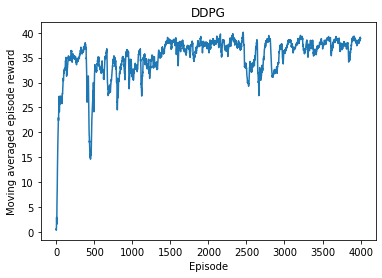

In [ ]:
import pickle
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import pandas as pd
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_num = 1000
torch.manual_seed(seed_num)
torch.cuda.manual_seed(seed_num)
torch.cuda.manual_seed_all(seed_num)
np.random.seed(seed_num)
random.seed(seed_num)


TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
Transition = namedtuple('Transition', ['s', 'a', 'r', 's_'])

gamma = 0.98
log_interval = 10

class ActorNet(nn.Module):

    def __init__(self):
        super(ActorNet, self).__init__()
        self.fc = nn.Linear(8, 100)
        self.mu_head = nn.Linear(100, 2)

    def forward(self, s):
        x = F.relu(self.fc(s))
        u = 2.0 * F.tanh(self.mu_head(x)) # pendulum task의 경우, action의 범위가 -2~2이므로, tanh를 활용하여 -1~1로 출력시키고 여기에 x2를 해준다.
        return u


class CriticNet(nn.Module):

    def __init__(self):
        super(CriticNet, self).__init__()
        self.fc = nn.Linear(10, 100)
        self.v_head = nn.Linear(100, 2)

    def forward(self, s, a):
        # print(s.shape, a.shape)
        # print(s, a, torch.cat([s, a], dim=1), sep = '\n\n')
        # s: tensor([[0.8553, -0.5181, 4.4607],[0.6519, -0.7583, 6.2618],[-0.8653, -0.5013, -6.8173], [0.1435, -0.9897, 7.0537]...  [0.1435, -1.9897, 5.053]]
        # a: tensor([[ 2.7781], [ 1.7413],[ 0.0121],[ 0.5088],[ 0.1754],... [0.1211]
        # tensor([[ 0.8553, -0.5181,  4.4607,  2.7781], [ 0.6519, -0.7583,  6.2618,  1.7413], [-0.8653, -0.5013, -6.8173,  0.0121], [ 0.1435, -0.9897,  7.0537,  0.5088],... [-0.8653, -0.5013, -6.8171,  0.1231]]

        x = F.relu(self.fc(torch.cat([s, a], dim=1)))
        state_value = self.v_head(x)  # 출력(state_value)은 선택된 1개의 action  (continuous value)
        return state_value            # 출력(state_value)은 선택된 1개의 action


class Memory():

    data_pointer = 0
    isfull = False

    def __init__(self, capacity):
        self.memory = np.empty(capacity, dtype=object)
        self.capacity = capacity

    def update(self, transition):
        self.memory[self.data_pointer] = transition
        self.data_pointer += 1
        if self.data_pointer == self.capacity:
            self.data_pointer = 0
            self.isfull = True

    def sample(self, batch_size):
        return np.random.choice(self.memory, batch_size)


class Agent():

    max_grad_norm = 0.5

    def __init__(self):
        self.training_step = 0
        self.var = 1.
        self.eval_cnet, self.target_cnet = CriticNet().float(), CriticNet().float()  # critic_main, critic_target
        self.eval_anet, self.target_anet = ActorNet().float(), ActorNet().float()    # actor_main, actor_target
        self.memory = Memory(2000)  # capacity = 2000
        self.optimizer_c = optim.Adam(self.eval_cnet.parameters(), lr=1e-3)
        self.optimizer_a = optim.Adam(self.eval_anet.parameters(), lr=3e-4)

    def select_action(self, state):
        # print('state:', state, type(state))  # 출력 : state: [-0.07907514 -0.99686867  7.2913437 ], <class 'numpy.ndarray'>
        state = torch.from_numpy(state).float().unsqueeze(0)
        mu = self.eval_anet(state) # actor_main의 출력 : action 값
        dist = Normal(mu, torch.tensor(self.var, dtype=torch.float))  # (for explore)  action = action + Noise 을 구현하고자, 평균이 mu이고 분산이 1인 가우시안 분포를 만들고
        action = dist.sample()                                        # 그 분포에서 1개의 값을 샘플링 함   => Noise를 더한것과 같은 효과
        action.clamp(-1.0, 1.0)                                       # 값이 -2~2를 넘어가지 않도록 제한 (깍기)
        # print(action)
        return action.squeeze(0).numpy()

    def save_param(self):
        torch.save(self.eval_anet.state_dict(), '/content/drive/MyDrive/강화학습/DDPG_ACTOR_model3.pth')
        torch.save(self.eval_cnet.state_dict(), '/content/drive/MyDrive/강화학습/DDPG_CRITIC_model3.pth')

    def store_transition(self, transition):
        self.memory.update(transition)

    def update(self):           # gradient update
        self.training_step += 1

        transitions = self.memory.sample(32)
        s = torch.tensor([t.s for t in transitions], dtype=torch.float)
        a = torch.tensor([t.a for t in transitions], dtype=torch.float)
        r = torch.tensor([t.r for t in transitions], dtype=torch.float).view(-1, 1)
        s_ = torch.tensor([t.s_ for t in transitions], dtype=torch.float)

        with torch.no_grad():
            q_target = r + gamma * self.target_cnet(s_, self.target_anet(s_))  # critic target 값 구하기 : actor_target으로 action을 얻어 (self.target_anet(s_)), critic_target(self.target_cnet)에 적용
        q_eval = self.eval_cnet(s, a)  # critic output 값 구하기 : critic_main 출력 값 (Q값)

        # update critic net
        self.optimizer_c.zero_grad()
        c_loss = F.smooth_l1_loss(q_eval, q_target)  # Critic의 Loss Function : Critic_Main과 Critic_target 간의 차이 (smooth_l1_loss)
        c_loss.backward()
        nn.utils.clip_grad_norm_(self.eval_cnet.parameters(), self.max_grad_norm)  # gradient clipping (vanishing gradient를 방지하기 위한 즉, 학습을 잘되게 하기 위한 skill - 강화학습에만 국한되는게 아니라 여러 머신러닝에서 사용하는 스킬)
        self.optimizer_c.step()

        # update actor net
        self.optimizer_a.zero_grad()
        a_loss = -self.eval_cnet(s, self.eval_anet(s)).mean() # gradient ascent이므로 (-) 적용,   Actor의 Loss function : mean of Critic's Q_Value
        a_loss.backward()
        nn.utils.clip_grad_norm_(self.eval_anet.parameters(), self.max_grad_norm)
        self.optimizer_a.step()

        if self.training_step % 200 == 0:
            self.target_cnet.load_state_dict(self.eval_cnet.state_dict())
        if self.training_step % 201 == 0:
            self.target_anet.load_state_dict(self.eval_anet.state_dict())

        self.var = max(self.var * 0.999, 0.01)

        return q_eval.mean().item()


def main():
    env = gym.make('Swimmer')
    agent = Agent()

    training_records = []
    return_list = []
    running_reward, running_q = 0, 0
    for i_ep in range(4000):
        score = 0
        state = env.reset()

        for t in range(200):
            action = agent.select_action(state)
            state_, reward, done, _ = env.step(action)
            score += reward
            agent.store_transition(Transition(state, action, reward , state_))  # (reward + 8) / 8 는 일종의 학습이 잘되기 위한 trick
            state = state_
            if agent.memory.isfull:
                q = agent.update()
                running_q = 0.99 * running_q + 0.01 * q

            if done:
                break

        running_reward = running_reward * 0.9 + score * 0.1

        training_records.append(TrainingRecord(i_ep, running_reward))
        return_list.append(score)
        pd.DataFrame(return_list).to_csv('/content/drive/MyDrive/강화학습/DDPG_model_record3.csv')

        if i_ep % log_interval == 0:
            print('Step {}\t score: {:.2f}\tAverage Q: {:.2f}'.format(
                i_ep, score, running_q))
            agent.save_param()
        #if running_reward > -200:
        #    print("Solved! Running reward is now {}!".format(running_reward))
        #    env.close()
        #    agent.save_param()
        #    with open('ddpg_training_records.pkl', 'wb') as f:
        #        pickle.dump(training_records, f)
        #    break
    agent.save_param()
    env.close()

    plt.plot([r.ep for r in training_records], [r.reward for r in training_records])
    plt.title('DDPG')
    plt.xlabel('Episode')
    plt.ylabel('Moving averaged episode reward')
    plt.savefig("ddpg3.png")


if __name__ == '__main__':
    main()

Step 0	 score: 25.26	Average Q: 0.00
Step 10	 score: 27.95	Average Q: -0.09
Step 20	 score: 8.34	Average Q: 1.97
Step 30	 score: 16.61	Average Q: 1.40
Step 40	 score: 16.60	Average Q: 1.45
Step 50	 score: 18.81	Average Q: 1.16
Step 60	 score: 22.64	Average Q: 1.02
Step 70	 score: 9.98	Average Q: 0.90
Step 80	 score: 9.38	Average Q: 1.05
Step 90	 score: 14.80	Average Q: 1.07
Step 100	 score: 18.00	Average Q: 1.19
Step 110	 score: 15.15	Average Q: 1.49
Step 120	 score: 14.25	Average Q: 1.02
Step 130	 score: 15.42	Average Q: 1.28
Step 140	 score: 10.17	Average Q: 0.94
Step 150	 score: 14.91	Average Q: 1.02
Step 160	 score: 15.87	Average Q: 1.45
Step 170	 score: 11.90	Average Q: 1.42
Step 180	 score: 7.63	Average Q: 1.02
Step 190	 score: 19.38	Average Q: 0.84
Step 200	 score: 19.90	Average Q: 1.07
Step 210	 score: 20.83	Average Q: 1.38
Step 220	 score: 18.21	Average Q: 1.02
Step 230	 score: 13.63	Average Q: 1.04
Step 240	 score: 8.84	Average Q: 0.95
Step 250	 score: 13.70	Average Q: 0.82
S

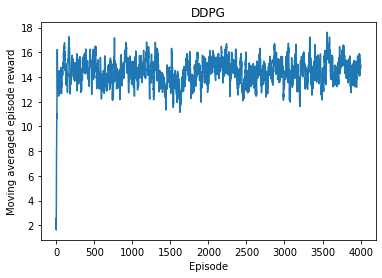

In [ ]:
import pickle
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import pandas as pd
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_num = 2022
torch.manual_seed(seed_num)
torch.cuda.manual_seed(seed_num)
torch.cuda.manual_seed_all(seed_num)
np.random.seed(seed_num)
random.seed(seed_num)


TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
Transition = namedtuple('Transition', ['s', 'a', 'r', 's_'])

gamma = 0.98
log_interval = 10

class ActorNet(nn.Module):

    def __init__(self):
        super(ActorNet, self).__init__()
        self.fc = nn.Linear(8, 100)
        self.mu_head = nn.Linear(100, 2)

    def forward(self, s):
        x = F.relu(self.fc(s))
        u = 2.0 * F.tanh(self.mu_head(x)) # pendulum task의 경우, action의 범위가 -2~2이므로, tanh를 활용하여 -1~1로 출력시키고 여기에 x2를 해준다.
        return u


class CriticNet(nn.Module):

    def __init__(self):
        super(CriticNet, self).__init__()
        self.fc = nn.Linear(10, 100)
        self.v_head = nn.Linear(100, 2)

    def forward(self, s, a):
        # print(s.shape, a.shape)
        # print(s, a, torch.cat([s, a], dim=1), sep = '\n\n')
        # s: tensor([[0.8553, -0.5181, 4.4607],[0.6519, -0.7583, 6.2618],[-0.8653, -0.5013, -6.8173], [0.1435, -0.9897, 7.0537]...  [0.1435, -1.9897, 5.053]]
        # a: tensor([[ 2.7781], [ 1.7413],[ 0.0121],[ 0.5088],[ 0.1754],... [0.1211]
        # tensor([[ 0.8553, -0.5181,  4.4607,  2.7781], [ 0.6519, -0.7583,  6.2618,  1.7413], [-0.8653, -0.5013, -6.8173,  0.0121], [ 0.1435, -0.9897,  7.0537,  0.5088],... [-0.8653, -0.5013, -6.8171,  0.1231]]

        x = F.relu(self.fc(torch.cat([s, a], dim=1)))
        state_value = self.v_head(x)  # 출력(state_value)은 선택된 1개의 action  (continuous value)
        return state_value            # 출력(state_value)은 선택된 1개의 action


class Memory():

    data_pointer = 0
    isfull = False

    def __init__(self, capacity):
        self.memory = np.empty(capacity, dtype=object)
        self.capacity = capacity

    def update(self, transition):
        self.memory[self.data_pointer] = transition
        self.data_pointer += 1
        if self.data_pointer == self.capacity:
            self.data_pointer = 0
            self.isfull = True

    def sample(self, batch_size):
        return np.random.choice(self.memory, batch_size)


class Agent():

    max_grad_norm = 0.5

    def __init__(self):
        self.training_step = 0
        self.var = 1.
        self.eval_cnet, self.target_cnet = CriticNet().float(), CriticNet().float()  # critic_main, critic_target
        self.eval_anet, self.target_anet = ActorNet().float(), ActorNet().float()    # actor_main, actor_target
        self.memory = Memory(2000)  # capacity = 2000
        self.optimizer_c = optim.Adam(self.eval_cnet.parameters(), lr=1e-3)
        self.optimizer_a = optim.Adam(self.eval_anet.parameters(), lr=3e-4)

    def select_action(self, state):
        # print('state:', state, type(state))  # 출력 : state: [-0.07907514 -0.99686867  7.2913437 ], <class 'numpy.ndarray'>
        state = torch.from_numpy(state).float().unsqueeze(0)
        mu = self.eval_anet(state) # actor_main의 출력 : action 값
        dist = Normal(mu, torch.tensor(self.var, dtype=torch.float))  # (for explore)  action = action + Noise 을 구현하고자, 평균이 mu이고 분산이 1인 가우시안 분포를 만들고
        action = dist.sample()                                        # 그 분포에서 1개의 값을 샘플링 함   => Noise를 더한것과 같은 효과
        action.clamp(-1.0, 1.0)                                       # 값이 -2~2를 넘어가지 않도록 제한 (깍기)
        # print(action)
        return action.squeeze(0).numpy()

    def save_param(self):
        torch.save(self.eval_anet.state_dict(), '/content/drive/MyDrive/강화학습/DDPG_ACTOR_model4.pth')
        torch.save(self.eval_cnet.state_dict(), '/content/drive/MyDrive/강화학습/DDPG_CRITIC_model4.pth')

    def store_transition(self, transition):
        self.memory.update(transition)

    def update(self):           # gradient update
        self.training_step += 1

        transitions = self.memory.sample(32)
        s = torch.tensor([t.s for t in transitions], dtype=torch.float)
        a = torch.tensor([t.a for t in transitions], dtype=torch.float)
        r = torch.tensor([t.r for t in transitions], dtype=torch.float).view(-1, 1)
        s_ = torch.tensor([t.s_ for t in transitions], dtype=torch.float)

        with torch.no_grad():
            q_target = r + gamma * self.target_cnet(s_, self.target_anet(s_))  # critic target 값 구하기 : actor_target으로 action을 얻어 (self.target_anet(s_)), critic_target(self.target_cnet)에 적용
        q_eval = self.eval_cnet(s, a)  # critic output 값 구하기 : critic_main 출력 값 (Q값)

        # update critic net
        self.optimizer_c.zero_grad()
        c_loss = F.smooth_l1_loss(q_eval, q_target)  # Critic의 Loss Function : Critic_Main과 Critic_target 간의 차이 (smooth_l1_loss)
        c_loss.backward()
        nn.utils.clip_grad_norm_(self.eval_cnet.parameters(), self.max_grad_norm)  # gradient clipping (vanishing gradient를 방지하기 위한 즉, 학습을 잘되게 하기 위한 skill - 강화학습에만 국한되는게 아니라 여러 머신러닝에서 사용하는 스킬)
        self.optimizer_c.step()

        # update actor net
        self.optimizer_a.zero_grad()
        a_loss = -self.eval_cnet(s, self.eval_anet(s)).mean() # gradient ascent이므로 (-) 적용,   Actor의 Loss function : mean of Critic's Q_Value
        a_loss.backward()
        nn.utils.clip_grad_norm_(self.eval_anet.parameters(), self.max_grad_norm)
        self.optimizer_a.step()

        if self.training_step % 200 == 0:
            self.target_cnet.load_state_dict(self.eval_cnet.state_dict())
        if self.training_step % 201 == 0:
            self.target_anet.load_state_dict(self.eval_anet.state_dict())

        self.var = max(self.var * 0.999, 0.01)

        return q_eval.mean().item()


def main():
    env = gym.make('Swimmer')
    agent = Agent()

    training_records = []
    return_list = []
    running_reward, running_q = 0, 0
    for i_ep in range(4000):
        score = 0
        state = env.reset()

        for t in range(200):
            action = agent.select_action(state)
            state_, reward, done, _ = env.step(action)
            score += reward
            agent.store_transition(Transition(state, action, reward , state_))  # (reward + 8) / 8 는 일종의 학습이 잘되기 위한 trick
            state = state_
            if agent.memory.isfull:
                q = agent.update()
                running_q = 0.99 * running_q + 0.01 * q

            if done:
                break

        running_reward = running_reward * 0.9 + score * 0.1

        training_records.append(TrainingRecord(i_ep, running_reward))
        return_list.append(score)
        pd.DataFrame(return_list).to_csv('/content/drive/MyDrive/강화학습/DDPG_model_record4.csv')

        if i_ep % log_interval == 0:
            print('Step {}\t score: {:.2f}\tAverage Q: {:.2f}'.format(
                i_ep, score, running_q))
            agent.save_param()
        #if running_reward > -200:
        #    print("Solved! Running reward is now {}!".format(running_reward))
        #    env.close()
        #    agent.save_param()
        #    with open('ddpg_training_records.pkl', 'wb') as f:
        #        pickle.dump(training_records, f)
        #    break
    agent.save_param()
    env.close()

    plt.plot([r.ep for r in training_records], [r.reward for r in training_records])
    plt.title('DDPG')
    plt.xlabel('Episode')
    plt.ylabel('Moving averaged episode reward')
    plt.savefig("ddpg4.png")


if __name__ == '__main__':
    main()

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:601: UserWarning: WARN: Using the latest versioned environment `Swimmer-v4` instead of the unversioned environment `Swimmer`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use t

Step 0	 score: 3.53	Average Q: 0.00
Step 10	 score: -2.11	Average Q: -0.02
Step 20	 score: 23.79	Average Q: 4.75
Step 30	 score: 24.86	Average Q: 4.82
Step 40	 score: 27.85	Average Q: 4.59
Step 50	 score: 24.79	Average Q: 4.28
Step 60	 score: 27.36	Average Q: 3.84
Step 70	 score: 28.44	Average Q: 3.49
Step 80	 score: 31.99	Average Q: 3.84
Step 90	 score: 34.15	Average Q: 4.25
Step 100	 score: 13.45	Average Q: 4.99
Step 110	 score: 34.25	Average Q: 5.06
Step 120	 score: 32.36	Average Q: 5.37
Step 130	 score: 30.21	Average Q: 5.10
Step 140	 score: 32.61	Average Q: 5.30
Step 150	 score: 36.68	Average Q: 5.57
Step 160	 score: 32.87	Average Q: 5.21
Step 170	 score: 30.68	Average Q: 5.79
Step 180	 score: 34.70	Average Q: 5.50
Step 190	 score: 34.04	Average Q: 5.49
Step 200	 score: 32.52	Average Q: 5.25
Step 210	 score: 34.99	Average Q: 5.37
Step 220	 score: 34.56	Average Q: 5.18
Step 230	 score: 35.34	Average Q: 5.17
Step 240	 score: 38.00	Average Q: 4.97
Step 250	 score: 34.95	Average Q: 5.

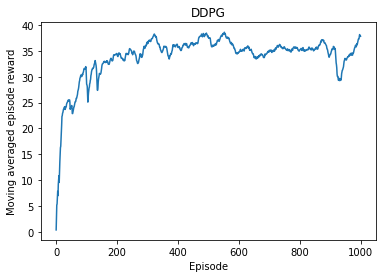

In [ ]:
import pickle
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import pandas as pd
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_num = 700
torch.manual_seed(seed_num)
torch.cuda.manual_seed(seed_num)
torch.cuda.manual_seed_all(seed_num)
np.random.seed(seed_num)
random.seed(seed_num)


TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
Transition = namedtuple('Transition', ['s', 'a', 'r', 's_'])

gamma = 0.98
log_interval = 10

class ActorNet(nn.Module):

    def __init__(self):
        super(ActorNet, self).__init__()
        self.fc = nn.Linear(8, 100)
        self.mu_head = nn.Linear(100, 2)

    def forward(self, s):
        x = F.relu(self.fc(s))
        u = 2.0 * F.tanh(self.mu_head(x)) # pendulum task의 경우, action의 범위가 -2~2이므로, tanh를 활용하여 -1~1로 출력시키고 여기에 x2를 해준다.
        return u


class CriticNet(nn.Module):

    def __init__(self):
        super(CriticNet, self).__init__()
        self.fc = nn.Linear(10, 100)
        self.v_head = nn.Linear(100, 2)

    def forward(self, s, a):
        # print(s.shape, a.shape)
        # print(s, a, torch.cat([s, a], dim=1), sep = '\n\n')
        # s: tensor([[0.8553, -0.5181, 4.4607],[0.6519, -0.7583, 6.2618],[-0.8653, -0.5013, -6.8173], [0.1435, -0.9897, 7.0537]...  [0.1435, -1.9897, 5.053]]
        # a: tensor([[ 2.7781], [ 1.7413],[ 0.0121],[ 0.5088],[ 0.1754],... [0.1211]
        # tensor([[ 0.8553, -0.5181,  4.4607,  2.7781], [ 0.6519, -0.7583,  6.2618,  1.7413], [-0.8653, -0.5013, -6.8173,  0.0121], [ 0.1435, -0.9897,  7.0537,  0.5088],... [-0.8653, -0.5013, -6.8171,  0.1231]]

        x = F.relu(self.fc(torch.cat([s, a], dim=1)))
        state_value = self.v_head(x)  # 출력(state_value)은 선택된 1개의 action  (continuous value)
        return state_value            # 출력(state_value)은 선택된 1개의 action


class Memory():

    data_pointer = 0
    isfull = False

    def __init__(self, capacity):
        self.memory = np.empty(capacity, dtype=object)
        self.capacity = capacity

    def update(self, transition):
        self.memory[self.data_pointer] = transition
        self.data_pointer += 1
        if self.data_pointer == self.capacity:
            self.data_pointer = 0
            self.isfull = True

    def sample(self, batch_size):
        return np.random.choice(self.memory, batch_size)


class Agent():

    max_grad_norm = 0.5

    def __init__(self):
        self.training_step = 0
        self.var = 1.
        self.eval_cnet, self.target_cnet = CriticNet().float(), CriticNet().float()  # critic_main, critic_target
        self.eval_anet, self.target_anet = ActorNet().float(), ActorNet().float()    # actor_main, actor_target
        self.memory = Memory(2000)  # capacity = 2000
        self.optimizer_c = optim.Adam(self.eval_cnet.parameters(), lr=1e-3)
        self.optimizer_a = optim.Adam(self.eval_anet.parameters(), lr=3e-4)

    def select_action(self, state):
        # print('state:', state, type(state))  # 출력 : state: [-0.07907514 -0.99686867  7.2913437 ], <class 'numpy.ndarray'>
        state = torch.from_numpy(state).float().unsqueeze(0)
        mu = self.eval_anet(state) # actor_main의 출력 : action 값
        dist = Normal(mu, torch.tensor(self.var, dtype=torch.float))  # (for explore)  action = action + Noise 을 구현하고자, 평균이 mu이고 분산이 1인 가우시안 분포를 만들고
        action = dist.sample()                                        # 그 분포에서 1개의 값을 샘플링 함   => Noise를 더한것과 같은 효과
        action.clamp(-1.0, 1.0)                                       # 값이 -2~2를 넘어가지 않도록 제한 (깍기)
        # print(action)
        return action.squeeze(0).numpy()

    def save_param(self):
        torch.save(self.eval_anet.state_dict(), '/content/drive/MyDrive/강화학습/DDPG_ACTOR_model2.pth')
        torch.save(self.eval_cnet.state_dict(), '/content/drive/MyDrive/강화학습/DDPG_CRITIC_model2.pth')

    def store_transition(self, transition):
        self.memory.update(transition)

    def update(self):           # gradient update
        self.training_step += 1

        transitions = self.memory.sample(32)
        s = torch.tensor([t.s for t in transitions], dtype=torch.float)
        a = torch.tensor([t.a for t in transitions], dtype=torch.float)
        r = torch.tensor([t.r for t in transitions], dtype=torch.float).view(-1, 1)
        s_ = torch.tensor([t.s_ for t in transitions], dtype=torch.float)

        with torch.no_grad():
            q_target = r + gamma * self.target_cnet(s_, self.target_anet(s_))  # critic target 값 구하기 : actor_target으로 action을 얻어 (self.target_anet(s_)), critic_target(self.target_cnet)에 적용
        q_eval = self.eval_cnet(s, a)  # critic output 값 구하기 : critic_main 출력 값 (Q값)

        # update critic net
        self.optimizer_c.zero_grad()
        c_loss = F.smooth_l1_loss(q_eval, q_target)  # Critic의 Loss Function : Critic_Main과 Critic_target 간의 차이 (smooth_l1_loss)
        c_loss.backward()
        nn.utils.clip_grad_norm_(self.eval_cnet.parameters(), self.max_grad_norm)  # gradient clipping (vanishing gradient를 방지하기 위한 즉, 학습을 잘되게 하기 위한 skill - 강화학습에만 국한되는게 아니라 여러 머신러닝에서 사용하는 스킬)
        self.optimizer_c.step()

        # update actor net
        self.optimizer_a.zero_grad()
        a_loss = -self.eval_cnet(s, self.eval_anet(s)).mean() # gradient ascent이므로 (-) 적용,   Actor의 Loss function : mean of Critic's Q_Value
        a_loss.backward()
        nn.utils.clip_grad_norm_(self.eval_anet.parameters(), self.max_grad_norm)
        self.optimizer_a.step()

        if self.training_step % 200 == 0:
            self.target_cnet.load_state_dict(self.eval_cnet.state_dict())
        if self.training_step % 201 == 0:
            self.target_anet.load_state_dict(self.eval_anet.state_dict())

        self.var = max(self.var * 0.999, 0.01)

        return q_eval.mean().item()


def main():
    env = gym.make('Swimmer')
    agent = Agent()

    training_records = []
    return_list = []
    running_reward, running_q = 0, 0
    for i_ep in range(1000):
        score = 0
        state = env.reset()

        for t in range(200):
            action = agent.select_action(state)
            # print(action.shape, state.shape)
            state_, reward, done, _ = env.step(action)
            # if i_ep >= 100: env.render()
            score += reward
            # if args.render:
            #     if i_ep >= 50: env.render()
            agent.store_transition(Transition(state, action, reward , state_))  # (reward + 8) / 8 는 일종의 학습이 잘되기 위한 trick
            state = state_
            if agent.memory.isfull:
                q = agent.update()
                running_q = 0.99 * running_q + 0.01 * q

            if done:
                break

        running_reward = running_reward * 0.9 + score * 0.1

        training_records.append(TrainingRecord(i_ep, running_reward))
        return_list.append(score)
        pd.DataFrame(return_list).to_csv('/content/drive/MyDrive/강화학습/DDPG_model_record2.csv')

        if i_ep % log_interval == 0:
            print('Step {}\t score: {:.2f}\tAverage Q: {:.2f}'.format(
                i_ep, score, running_q))
            agent.save_param()
        #if running_reward > -200:
        #    print("Solved! Running reward is now {}!".format(running_reward))
        #    env.close()
        #    agent.save_param()
        #    with open('ddpg_training_records.pkl', 'wb') as f:
        #        pickle.dump(training_records, f)
        #    break
    agent.save_param()
    env.close()

    plt.plot([r.ep for r in training_records], [r.reward for r in training_records])
    plt.title('DDPG')
    plt.xlabel('Episode')
    plt.ylabel('Moving averaged episode reward')
    plt.savefig("ddpg2.png")


if __name__ == '__main__':
    main()

In [ ]:
# !python DDPG_swimmer.py

import pickle
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import pandas as pd
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_num = 0
torch.manual_seed(seed_num)
torch.cuda.manual_seed(seed_num)
torch.cuda.manual_seed_all(seed_num)
np.random.seed(seed_num)
random.seed(seed_num)


TrainingRecord = namedtuple('TrainingRecord', ['ep', 'reward'])
Transition = namedtuple('Transition', ['s', 'a', 'r', 's_'])

gamma = 0.98
log_interval = 10

class ActorNet(nn.Module):

    def __init__(self):
        super(ActorNet, self).__init__()
        self.fc = nn.Linear(8, 100)
        self.mu_head = nn.Linear(100, 2)

    def forward(self, s):
        x = F.relu(self.fc(s))
        u = 2.0 * F.tanh(self.mu_head(x)) # pendulum task의 경우, action의 범위가 -2~2이므로, tanh를 활용하여 -1~1로 출력시키고 여기에 x2를 해준다.
        return u


class CriticNet(nn.Module):

    def __init__(self):
        super(CriticNet, self).__init__()
        self.fc = nn.Linear(10, 100)
        self.v_head = nn.Linear(100, 2)

    def forward(self, s, a):
        # print(s.shape, a.shape)
        # print(s, a, torch.cat([s, a], dim=1), sep = '\n\n')
        # s: tensor([[0.8553, -0.5181, 4.4607],[0.6519, -0.7583, 6.2618],[-0.8653, -0.5013, -6.8173], [0.1435, -0.9897, 7.0537]...  [0.1435, -1.9897, 5.053]]
        # a: tensor([[ 2.7781], [ 1.7413],[ 0.0121],[ 0.5088],[ 0.1754],... [0.1211]
        # tensor([[ 0.8553, -0.5181,  4.4607,  2.7781], [ 0.6519, -0.7583,  6.2618,  1.7413], [-0.8653, -0.5013, -6.8173,  0.0121], [ 0.1435, -0.9897,  7.0537,  0.5088],... [-0.8653, -0.5013, -6.8171,  0.1231]]

        x = F.relu(self.fc(torch.cat([s, a], dim=1)))
        state_value = self.v_head(x)  # 출력(state_value)은 선택된 1개의 action  (continuous value)
        return state_value            # 출력(state_value)은 선택된 1개의 action


class Memory():

    data_pointer = 0
    isfull = False

    def __init__(self, capacity):
        self.memory = np.empty(capacity, dtype=object)
        self.capacity = capacity

    def update(self, transition):
        self.memory[self.data_pointer] = transition
        self.data_pointer += 1
        if self.data_pointer == self.capacity:
            self.data_pointer = 0
            self.isfull = True

    def sample(self, batch_size):
        return np.random.choice(self.memory, batch_size)


class Agent():

    max_grad_norm = 0.5

    def __init__(self):
        self.training_step = 0
        self.var = 1.
        self.eval_cnet, self.target_cnet = CriticNet().float(), CriticNet().float()  # critic_main, critic_target
        self.eval_anet, self.target_anet = ActorNet().float(), ActorNet().float()    # actor_main, actor_target
        self.memory = Memory(2000)  # capacity = 2000
        self.optimizer_c = optim.Adam(self.eval_cnet.parameters(), lr=1e-3)
        self.optimizer_a = optim.Adam(self.eval_anet.parameters(), lr=3e-4)

    def select_action(self, state):
        # print('state:', state, type(state))  # 출력 : state: [-0.07907514 -0.99686867  7.2913437 ], <class 'numpy.ndarray'>
        state = torch.from_numpy(state).float().unsqueeze(0)
        mu = self.eval_anet(state) # actor_main의 출력 : action 값
        dist = Normal(mu, torch.tensor(self.var, dtype=torch.float))  # (for explore)  action = action + Noise 을 구현하고자, 평균이 mu이고 분산이 1인 가우시안 분포를 만들고
        action = dist.sample()                                        # 그 분포에서 1개의 값을 샘플링 함   => Noise를 더한것과 같은 효과
        action.clamp(-1.0, 1.0)                                       # 값이 -2~2를 넘어가지 않도록 제한 (깍기)
        # print(action)
        return action.squeeze(0).numpy()

    def save_param(self):
        torch.save(self.eval_anet.state_dict(), '/content/drive/MyDrive/강화학습/DDPG_ACTOR_model2.pth')
        torch.save(self.eval_cnet.state_dict(), '/content/drive/MyDrive/강화학습/DDPG_CRITIC_model2.pth')

    def store_transition(self, transition):
        self.memory.update(transition)

    def update(self):           # gradient update
        self.training_step += 1

        transitions = self.memory.sample(32)
        s = torch.tensor([t.s for t in transitions], dtype=torch.float)
        a = torch.tensor([t.a for t in transitions], dtype=torch.float)
        r = torch.tensor([t.r for t in transitions], dtype=torch.float).view(-1, 1)
        s_ = torch.tensor([t.s_ for t in transitions], dtype=torch.float)

        with torch.no_grad():
            q_target = r + gamma * self.target_cnet(s_, self.target_anet(s_))  # critic target 값 구하기 : actor_target으로 action을 얻어 (self.target_anet(s_)), critic_target(self.target_cnet)에 적용
        q_eval = self.eval_cnet(s, a)  # critic output 값 구하기 : critic_main 출력 값 (Q값)

        # update critic net
        self.optimizer_c.zero_grad()
        c_loss = F.smooth_l1_loss(q_eval, q_target)  # Critic의 Loss Function : Critic_Main과 Critic_target 간의 차이 (smooth_l1_loss)
        c_loss.backward()
        nn.utils.clip_grad_norm_(self.eval_cnet.parameters(), self.max_grad_norm)  # gradient clipping (vanishing gradient를 방지하기 위한 즉, 학습을 잘되게 하기 위한 skill - 강화학습에만 국한되는게 아니라 여러 머신러닝에서 사용하는 스킬)
        self.optimizer_c.step()

        # update actor net
        self.optimizer_a.zero_grad()
        a_loss = -self.eval_cnet(s, self.eval_anet(s)).mean() # gradient ascent이므로 (-) 적용,   Actor의 Loss function : mean of Critic's Q_Value
        a_loss.backward()
        nn.utils.clip_grad_norm_(self.eval_anet.parameters(), self.max_grad_norm)
        self.optimizer_a.step()

        if self.training_step % 200 == 0:
            self.target_cnet.load_state_dict(self.eval_cnet.state_dict())
        if self.training_step % 201 == 0:
            self.target_anet.load_state_dict(self.eval_anet.state_dict())

        self.var = max(self.var * 0.999, 0.01)

        return q_eval.mean().item()


def main():
    env = gym.make('Swimmer')
    agent = Agent()

    training_records = []
    return_list = []
    running_reward, running_q = 0, 0
    for i_ep in range(1000):
        score = 0
        state = env.reset()

        for t in range(200):
            action = agent.select_action(state)
            # print(action.shape, state.shape)
            state_, reward, done, _ = env.step(action)
            # if i_ep >= 100: env.render()
            score += reward
            # if args.render:
            #     if i_ep >= 50: env.render()
            agent.store_transition(Transition(state, action, reward , state_))  # (reward + 8) / 8 는 일종의 학습이 잘되기 위한 trick
            state = state_
            if agent.memory.isfull:
                q = agent.update()
                running_q = 0.99 * running_q + 0.01 * q

            if done:
                break

        running_reward = running_reward * 0.9 + score * 0.1

        training_records.append(TrainingRecord(i_ep, running_reward))
        return_list.append(score)
        pd.DataFrame(return_list).to_csv('/content/drive/MyDrive/강화학습/DDPG_model_record2.csv')

        if i_ep % log_interval == 0:
            print('Step {}\t score: {:.2f}\tAverage Q: {:.2f}'.format(
                i_ep, score, running_q))
            agent.save_param()
        #if running_reward > -200:
        #    print("Solved! Running reward is now {}!".format(running_reward))
        #    env.close()
        #    agent.save_param()
        #    with open('ddpg_training_records.pkl', 'wb') as f:
        #        pickle.dump(training_records, f)
        #    break
    agent.save_param()
    env.close()

    plt.plot([r.ep for r in training_records], [r.reward for r in training_records])
    plt.title('DDPG')
    plt.xlabel('Episode')
    plt.ylabel('Moving averaged episode reward')
    plt.savefig("ddpg2.png")


if __name__ == '__main__':
    main()

/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:601: UserWarning: WARN: Using the latest versioned environment `Swimmer-v4` instead of the unversioned environment `Swimmer`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=s

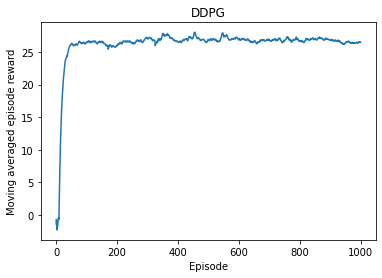

In [ ]:
ddpg_record = pd.read_csv('/content/drive/MyDrive/강화학습/DDPG_model_record.csv', index_col=0) 
plt.plot(ddpg_record)
plt.title('DDPG')
plt.xlabel('Episode')
plt.ylabel('Moving averaged episode reward')
plt.savefig("ddpg_seed0.png")

# DDPG Metric

In [ ]:
metric_0 = pd.read_csv('/content/drive/MyDrive/강화학습/DDPG_model_record.csv', index_col = 0).rename(columns = {'0':'return'})
metric_700 = pd.read_csv('/content/drive/MyDrive/강화학습/DDPG_model_record2_seed700.csv', index_col = 0).rename(columns = {'0':'return'})
metric_1000 = pd.read_csv('/content/drive/MyDrive/강화학습/DDPG_model_record3_seed1000.csv', index_col = 0).rename(columns = {'0':'return'})
metric_2022 = pd.read_csv('/content/drive/MyDrive/강화학습/DDPG_model_record4_seed2022.csv', index_col = 0).rename(columns = {'0':'return'})

In [ ]:
metric_0.iloc[-100:].describe()

,return
count,100.000000
mean,26.543208
std,0.188016
min,26.160302
25%,26.394048
50%,26.512036
75%,26.697853
max,26.943444


In [ ]:
metric_700.iloc[-100:].describe()

,return
count,100.000000
mean,34.187719
std,3.969014
min,19.996534
25%,32.737695
50%,34.838002
75%,36.765918
max,41.586996


In [ ]:
metric_1000.iloc[-100:].describe()

,return
count,100.000000
mean,38.371603
std,1.861572
min,32.727442
25%,37.089846
50%,38.382411
75%,39.613944
max,43.826350


In [ ]:
metric_2022.iloc[-100:].describe()

,return
count,100.000000
mean,14.639294
std,4.372540
min,4.563836
25%,11.592961
50%,14.729695
75%,18.069143
max,23.765650
